# Text Analysis in Python 4: Topics & Emotions

<h1 style="text-align:center;font-size:300%;"></h1> 
  <img src="" style="width:%80;">
  <!--<img src="http://www.languagetrainers.com/blog/wp-content/uploads/2012/10/us-are-vs-us-is1.png" style="width:%140;">-->



## Topic Modeling, Sentiment Analysis, and other Inductive Approaches to Text Analysis

## This Lesson

**one-sentence blurb**

In this session, participants will:
+ 

**more??**

*Explain Topic Modeling / Give Examples Of (both good and bad)
Present Buckets of Words Examples and have students interpret
Apply Topic Modeling to SOTU Texts (does it make sense to do so? it certainly would be interesting to see which SOTU addresses are lumped in with which others)
Compare to out-of-the-box approaches (Voyant, etc.)*

## Structure of Notebooks

These Jupyter Notebooks are designed to integrate instructions and explanations (in the white "markdown" cells below) with hands-on practice with the code (in the gray "code" cells below). To add, modify, or delete cells, please use the Menu above (especially under the Edit, Insert, and Cell tabs) or click ESC + H to see a list of keyboard shortcuts.

<h3 style="color:green">Code Together:</h3><p style="color:green">In these cell blocks, we will code together. You can find the completed version in our shared folder (ending with "_completed.ipynb").</p>

<h3 style="color:blue;">Exercises:</h3><p style="color:blue">are in blue text. These are a chance to practice what you have learned.</p>

<h3 style="color:purple">Python Basics - Additional Practice</h3><p style="color:purple">are in purple text. Work on these after the lesson if you would like more practice.</p>

In [1]:
import pathlib, os, re, nltk, gensim
import pandas as pd, numpy as np
import matplotlib
import matplotlib.pyplot as plt, seaborn as sns

from pathlib import Path

nltk.download('punkt')
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer
# from tqdm import tqdm_notebook as tqdm
from tqdm import notebook as tqdm
from tqdm import trange
from nltk import tokenize

plt.style.use('fivethirtyeight')
#%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 9] 
#%config InteractiveShellApp.matplotlib = 'inline'
#%config InlineBackend.figure_formats = ['svg']




[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\F0040RP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
#sotudf=pd.read_csv(Path(Path.cwd().parent,"state-of-the-union-dataset","sotudf.tsv"),encoding = "utf-8",sep="\t")
sotudir = Path(Path.cwd().parent,"state-of-the-union-dataset","txt")
sotudf = pd.read_csv(Path(sotudir.parent,"sotudf.tsv"),encoding="utf-8",sep="\t",index_col=0)

## Sentiment Analysis

[describe sentiment analysis]

The code used here was borrowed from https://github.com/raffg/harry_potter_nlp/blob/master/sentiment_analysis.ipynb.

In [43]:
#p = Path.cwd()
#p2 = p.parent
#sotudir = Path(p2,"state-of-the-union-dataset","txt")
print(Path.cwd())

print(sotudir)
pathlist = sotudir.glob("*.txt")
for path in pathlist:
    print(path)




C:\Users\F0040RP\Documents\DartLib_RDS\textAnalysis\topics-and-emotions
C:\Users\F0040RP\Documents\DartLib_RDS\textAnalysis\state-of-the-union-dataset\txt
C:\Users\F0040RP\Documents\DartLib_RDS\textAnalysis\state-of-the-union-dataset\txt\1790_Washington.txt
C:\Users\F0040RP\Documents\DartLib_RDS\textAnalysis\state-of-the-union-dataset\txt\1791_Washington.txt
C:\Users\F0040RP\Documents\DartLib_RDS\textAnalysis\state-of-the-union-dataset\txt\1792_Washington.txt
C:\Users\F0040RP\Documents\DartLib_RDS\textAnalysis\state-of-the-union-dataset\txt\1793_Washington.txt
C:\Users\F0040RP\Documents\DartLib_RDS\textAnalysis\state-of-the-union-dataset\txt\1794_Washington.txt
C:\Users\F0040RP\Documents\DartLib_RDS\textAnalysis\state-of-the-union-dataset\txt\1795_Washington.txt
C:\Users\F0040RP\Documents\DartLib_RDS\textAnalysis\state-of-the-union-dataset\txt\1796_Washington.txt
C:\Users\F0040RP\Documents\DartLib_RDS\textAnalysis\state-of-the-union-dataset\txt\1797_Adams.txt
C:\Users\F0040RP\Documents

2. Here, we will read a dataframe we created storing some metadata, the full text, and a tokenized list for each SOTU address (remember we created something similar in Lesson 2 "Counting Words", Step 16b).

In [6]:

sotudf.head()

pres  year  numtoks  \
0  Washington  1790        0   
1  Washington  1791     2314   
2  Washington  1792     2104   
3  Washington  1793     1973   
4  Washington  1794     2918   

                                              tokens  \
0                                                 []   
1  ['Fellow', 'Citizens', 'of', 'the', 'Senate', ...   
2  ['Fellow', 'Citizens', 'of', 'the', 'Senate', ...   
3  ['Fellow', 'Citizens', 'of', 'the', 'Senate', ...   
4  ['Fellow', 'Citizens', 'of', 'the', 'Senate', ...   

                                            fulltext  
0                                                NaN  
1  Fellow-Citizens of the Senate and House of Rep...  
2  Fellow-Citizens of the Senate and House of Rep...  
3  Fellow-Citizens of the Senate and House of Rep...  
4  Fellow-Citizens of the Senate and House of Rep...



3. Next, we will create a new column in our SOTU dataframe to store the full text of each address after processing each a bit further.

In [7]:
print(sotudf.iloc[1]['fulltext'][:400],"\n***\n")

Fellow-Citizens of the Senate and House of Representatives:

"In vain may we expect peace with the Indians on our frontiers so long as a
lawless set of unprincipled wretches can violate the rights of hospitality,
or infringe the most solemn treaties, without receiving the punishment they
so justly merit."

I meet you upon the present occasion with the feelings which are naturally
inspired by a str 
***



In [8]:
#sotudf.iloc[0]['fulltext']
#sotudf.fulltext.apply(type)
print(sotudf.shape)
sotudf = sotudf[sotudf['fulltext']!=""]
print(sotudf.shape)
sotudf = sotudf[sotudf['fulltext'].notnull()]
print(sotudf.shape)

(228, 5)
(228, 5)
(227, 5)


In [9]:
sotudf['text_processed'] = sotudf['fulltext'].map(lambda x: re.sub('[,\.!?\"]', '', x)) #removes common punctuation
print(sotudf.iloc[0]['text_processed'][:400],"\n***\n")


Fellow-Citizens of the Senate and House of Representatives:

In vain may we expect peace with the Indians on our frontiers so long as a
lawless set of unprincipled wretches can violate the rights of hospitality
or infringe the most solemn treaties without receiving the punishment they
so justly merit

I meet you upon the present occasion with the feelings which are naturally
inspired by a strong i 
***



In [10]:
sotudf['text_processed'] = sotudf['text_processed'].map(lambda x: x.lower())
print(sotudf.iloc[0]['text_processed'][:400],"\n***\n")

fellow-citizens of the senate and house of representatives:

in vain may we expect peace with the indians on our frontiers so long as a
lawless set of unprincipled wretches can violate the rights of hospitality
or infringe the most solemn treaties without receiving the punishment they
so justly merit

i meet you upon the present occasion with the feelings which are naturally
inspired by a strong i 
***



In [11]:
sotudf.head()

pres  year  numtoks  \
1  Washington  1791     2314   
2  Washington  1792     2104   
3  Washington  1793     1973   
4  Washington  1794     2918   
5  Washington  1795     1988   

                                              tokens  \
1  ['Fellow', 'Citizens', 'of', 'the', 'Senate', ...   
2  ['Fellow', 'Citizens', 'of', 'the', 'Senate', ...   
3  ['Fellow', 'Citizens', 'of', 'the', 'Senate', ...   
4  ['Fellow', 'Citizens', 'of', 'the', 'Senate', ...   
5  ['Fellow', 'Citizens', 'of', 'the', 'Senate', ...   

                                            fulltext  \
1  Fellow-Citizens of the Senate and House of Rep...   
2  Fellow-Citizens of the Senate and House of Rep...   
3  Fellow-Citizens of the Senate and House of Rep...   
4  Fellow-Citizens of the Senate and House of Rep...   
5  Fellow-Citizens of the Senate and House of Rep...   

                                      text_processed  
1  fellow-citizens of the senate and house of rep...  
2  fellow-citizens of the senate and house of rep...  
3  fellow-citizens of the senate and house of rep...  
4  fellow-citizens of the senate and house of rep...  
5  fellow-citizens of the senate and house of rep...

In [ ]:
def text_emotion(df, column):
    '''
    Takes a DataFrame and a specified column of text and adds 10 columns to the
    DataFrame for each of the 10 emotions in the NRC Emotion Lexicon, with each
    column containing the value of the text in that emotion
    INPUT: DataFrame, string
    OUTPUT: the original DataFrame with ten new columns
    '''

    new_df = df.copy()
    # new_df = sotudf2.copy()

    # filepath = ('data/'
    #             'NRC-Sentiment-Emotion-Lexicons/'
    #             'NRC-Emotion-Lexicon-v0.92/'
    #             'NRC-Emotion-Lexicon-Wordlevel-v0.92.txt')
    
    #filepath = "C:/Users/F0040RP/Documents/Python_Scripts/sentimentAnalysis/NRC-Emotion-Lexicon/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
    filepath = Path('NRC-Emotion-Lexicon','NRC-Emotion-Lexicon-Wordlevel-v0.92.txt')
    
    emolex_df = pd.read_csv(filepath,
                            names=["word", "emotion", "association"],
                            sep='\t')
    emolex_words = emolex_df.pivot(index='word',
                                   columns='emotion',
                                   values='association').reset_index()
    
    emotions = emolex_words.columns.drop('word')
    emo_df = pd.DataFrame(0, index=df.index, columns=emotions)
    # emo_df = pd.DataFrame(0,index=sotudf2.index, columns = emotions)
    stemmer = SnowballStemmer("english")

    
    president = ''
    year = ''
    
    with tqdm.tqdm(total=len(list(new_df.iterrows()))) as pbar:
        for i, row in new_df.iterrows():
            pbar.update(1)
            if row['pres'] != president:
                print(row['pres'])
                president = row['pres']
            if row['year'] != year:
                print('   ', row['year'])
                year = row['year']
                # chap = row['year']
            document = word_tokenize(new_df.loc[i][column])
            for word in document:
                word = stemmer.stem(word.lower())
                emo_score = emolex_words[emolex_words.word == word]
                if not emo_score.empty:
                    for emotion in list(emotions):
                        emo_df.at[i, emotion] += emo_score[emotion]

    new_df = pd.concat([new_df, emo_df], axis=1)

    return new_df

# the below takes a long time, 1:26 on my cpu!

In [12]:
sotudf2 = text_emotion(sotudf,'fulltext')
## just create a sample version - maybe 3 texts



  0%|          | 0/227 [00:00<?, ?it/s]

Washington
    1791
    1792
    1793
    1794
    1795
    1796
Adams
    1797
    1798
    1799
    1800
Jefferson
    1801
    1802
    1803
    1804
    1805
    1806
    1807
    1808
Madison
    1809
    1810
    1811
    1812
    1813
    1814
    1815
    1816
Monroe
    1817
    1818
    1819
    1820
    1821
    1822
    1823
    1824
Adams
    1825
    1826
    1827
    1828
Jackson
    1829
    1830
    1831
    1832
    1833
    1834
    1835
    1836
Buren
    1837
    1838
    1839
    1840
Tyler
    1841
    1842
    1843
    1844
Polk
    1845
    1846
    1847
    1848
Taylor
    1849
Fillmore
    1850
    1851
    1852
Pierce
    1853
    1854
    1855
    1856
Buchanan
    1857
    1858
    1859
    1860
Lincoln
    1861
    1862
    1863
    1864
Johnson
    1865
    1866
    1867
    1868
Grant
    1869
    1870
    1871
    1872
    1873
    1874
    1875
    1876
Hayes
    1877
    1878
    1879
    1880
Arthur
    1881
    1882
    1883
    1884
Cleveland
    

pres  year  numtoks  \
1  Washington  1791     2314   
2  Washington  1792     2104   
3  Washington  1793     1973   
4  Washington  1794     2918   
5  Washington  1795     1988   

                                              tokens  \
1  ['Fellow', 'Citizens', 'of', 'the', 'Senate', ...   
2  ['Fellow', 'Citizens', 'of', 'the', 'Senate', ...   
3  ['Fellow', 'Citizens', 'of', 'the', 'Senate', ...   
4  ['Fellow', 'Citizens', 'of', 'the', 'Senate', ...   
5  ['Fellow', 'Citizens', 'of', 'the', 'Senate', ...   

                                            fulltext  \
1  Fellow-Citizens of the Senate and House of Rep...   
2  Fellow-Citizens of the Senate and House of Rep...   
3  Fellow-Citizens of the Senate and House of Rep...   
4  Fellow-Citizens of the Senate and House of Rep...   
5  Fellow-Citizens of the Senate and House of Rep...   

                                      text_processed  anger  anticipation  \
1  fellow-citizens of the senate and house of rep...     11            55   
2  fellow-citizens of the senate and house of rep...     14            51   
3  fellow-citizens of the senate and house of rep...     15            46   
4  fellow-citizens of the senate and house of rep...     47            63   
5  fellow-citizens of the senate and house of rep...     22            60   

   disgust  fear  joy  negative  positive  sadness  surprise  trust  
1        8    17   38        42       117       21        18     89  
2        8    25   36        52       111       21        17    119  
3       14    28   33        51       100       20        15     88  
4       23    54   44        90       160       40        25    126  
5       18    30   45        57       124       30        26     93

Let's take a look what this new dataset looks like:

In [13]:
sotudf2.head()

pres  year  numtoks  \
1  Washington  1791     2314   
2  Washington  1792     2104   
3  Washington  1793     1973   
4  Washington  1794     2918   
5  Washington  1795     1988   

                                              tokens  \
1  ['Fellow', 'Citizens', 'of', 'the', 'Senate', ...   
2  ['Fellow', 'Citizens', 'of', 'the', 'Senate', ...   
3  ['Fellow', 'Citizens', 'of', 'the', 'Senate', ...   
4  ['Fellow', 'Citizens', 'of', 'the', 'Senate', ...   
5  ['Fellow', 'Citizens', 'of', 'the', 'Senate', ...   

                                            fulltext  \
1  Fellow-Citizens of the Senate and House of Rep...   
2  Fellow-Citizens of the Senate and House of Rep...   
3  Fellow-Citizens of the Senate and House of Rep...   
4  Fellow-Citizens of the Senate and House of Rep...   
5  Fellow-Citizens of the Senate and House of Rep...   

                                      text_processed  anger  anticipation  \
1  fellow-citizens of the senate and house of rep...     11            55   
2  fellow-citizens of the senate and house of rep...     14            51   
3  fellow-citizens of the senate and house of rep...     15            46   
4  fellow-citizens of the senate and house of rep...     47            63   
5  fellow-citizens of the senate and house of rep...     22            60   

   disgust  fear  joy  negative  positive  sadness  surprise  trust  
1        8    17   38        42       117       21        18     89  
2        8    25   36        52       111       21        17    119  
3       14    28   33        51       100       20        15     88  
4       23    54   44        90       160       40        25    126  
5       18    30   45        57       124       30        26     93

WindowsPath('C:/Users/F0040RP/Documents/DartLib_RDS/textAnalysis/topics-and-emotions')

In [16]:
sotunrc = sotudf2.drop(["fulltext","text_processed"],axis=1)
sotunrc.to_csv("sotu_nrc.csv",encoding = "utf-8")

In [ ]:
#then load nrc sentiment analysis results
sotunrc2=pd.read_csv("sotu_nrc.csv",encoding = "utf-8")

In [19]:
sotunrc2 = sotunrc.copy()

In [20]:
emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']
for emotion in emotions:
    sotunrc2[emotion] = sotunrc2[emotion] / sotunrc2['numtoks']
sotunrc2.head()

pres  year  numtoks  \
1  Washington  1791     2314   
2  Washington  1792     2104   
3  Washington  1793     1973   
4  Washington  1794     2918   
5  Washington  1795     1988   

                                              tokens     anger  anticipation  \
1  ['Fellow', 'Citizens', 'of', 'the', 'Senate', ...  0.004754      0.023768   
2  ['Fellow', 'Citizens', 'of', 'the', 'Senate', ...  0.006654      0.024240   
3  ['Fellow', 'Citizens', 'of', 'the', 'Senate', ...  0.007603      0.023315   
4  ['Fellow', 'Citizens', 'of', 'the', 'Senate', ...  0.016107      0.021590   
5  ['Fellow', 'Citizens', 'of', 'the', 'Senate', ...  0.011066      0.030181   

    disgust      fear       joy  negative  positive   sadness  surprise  \
1  0.003457  0.007347  0.016422  0.018150  0.050562  0.009075  0.007779   
2  0.003802  0.011882  0.017110  0.024715  0.052757  0.009981  0.008080   
3  0.007096  0.014192  0.016726  0.025849  0.050684  0.010137  0.007603   
4  0.007882  0.018506  0.015079  0.030843  0.054832  0.013708  0.008568   
5  0.009054  0.015091  0.022636  0.028672  0.062374  0.015091  0.013078   

      trust  
1  0.038462  
2  0.056559  
3  0.044602  
4  0.043180  
5  0.046781

In [21]:
sotunrc2.to_csv("sotu_nrc_pct.csv", encoding = "utf-8")

In [ ]:
#if I need to add back in dropped columns (["text","text_processed","word_count"])
#sotudf3 = pd.merge(sotudf,sotunrc,how="inner",on=["year","president"])

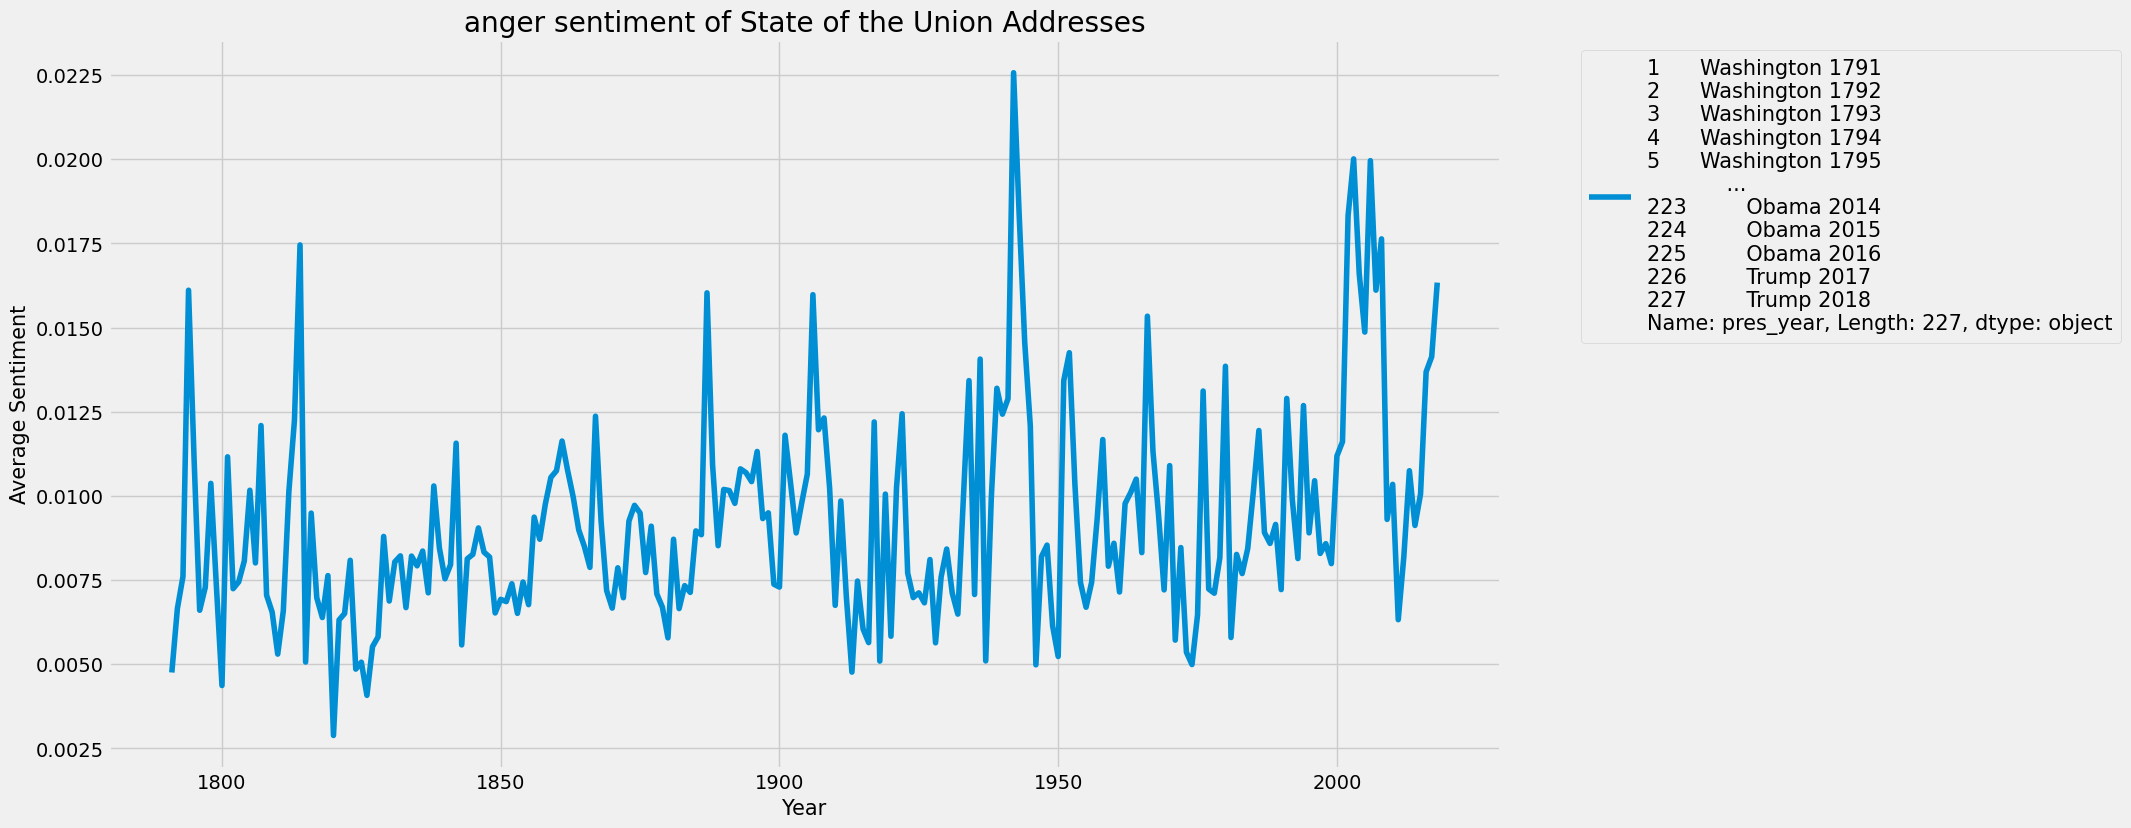

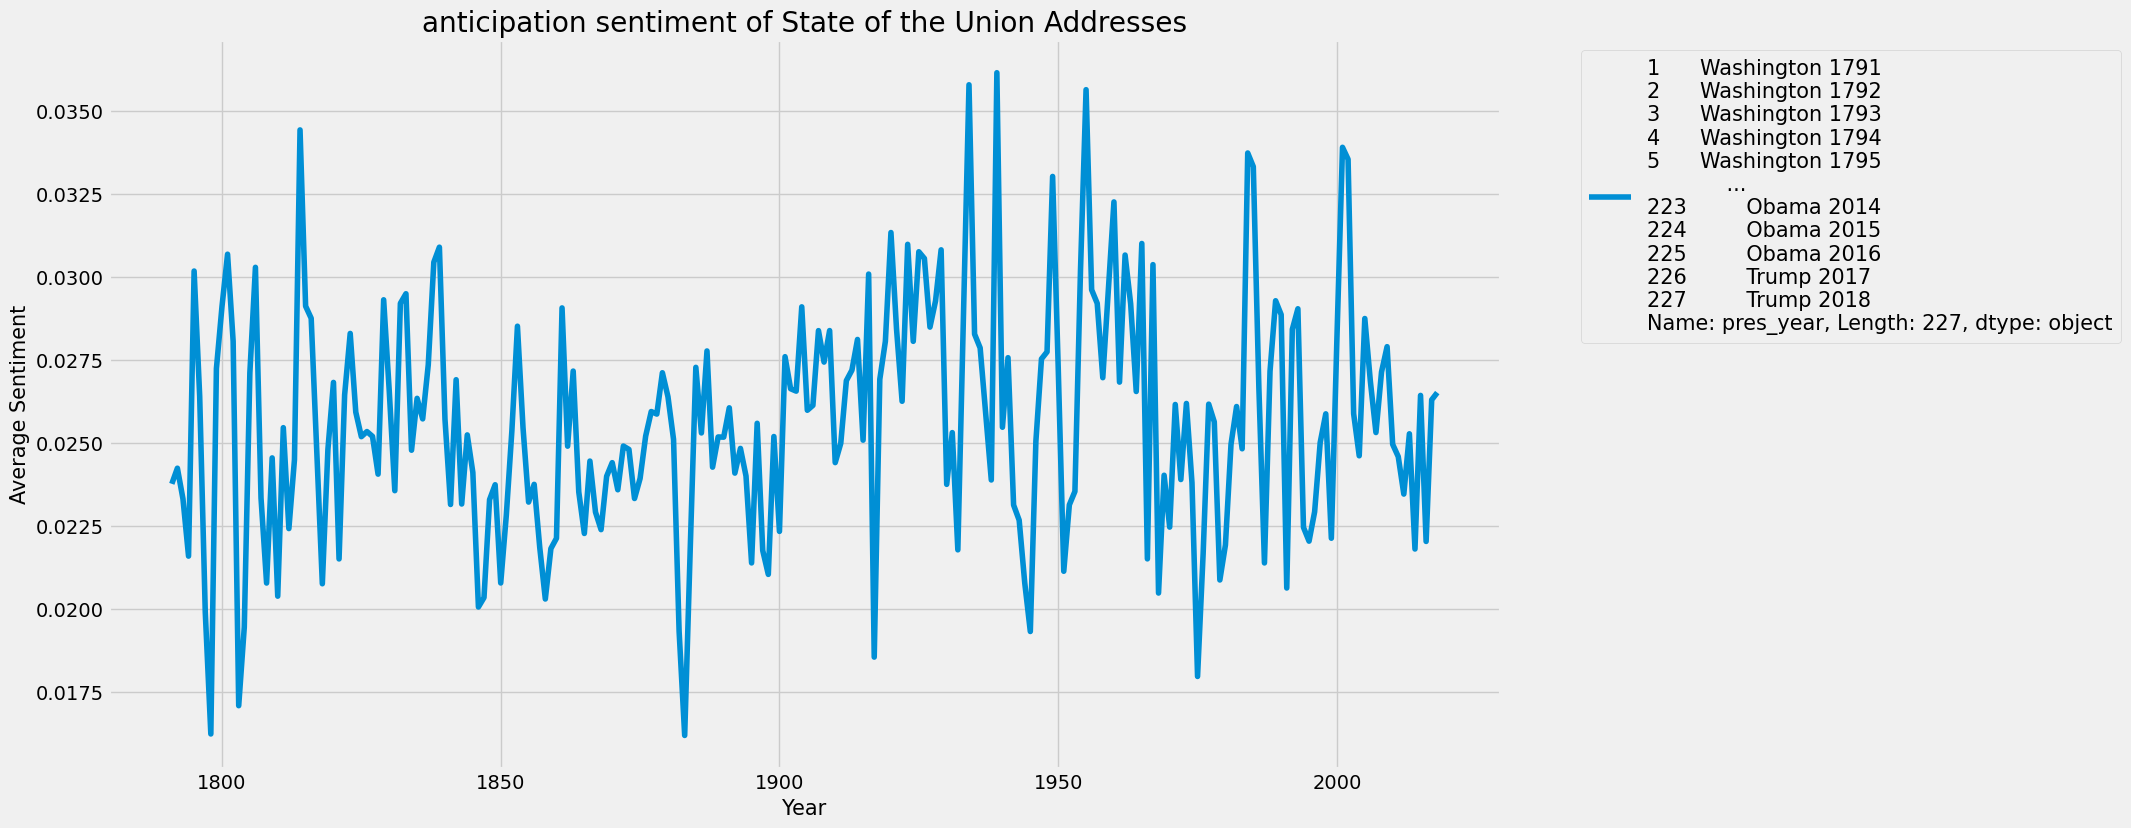

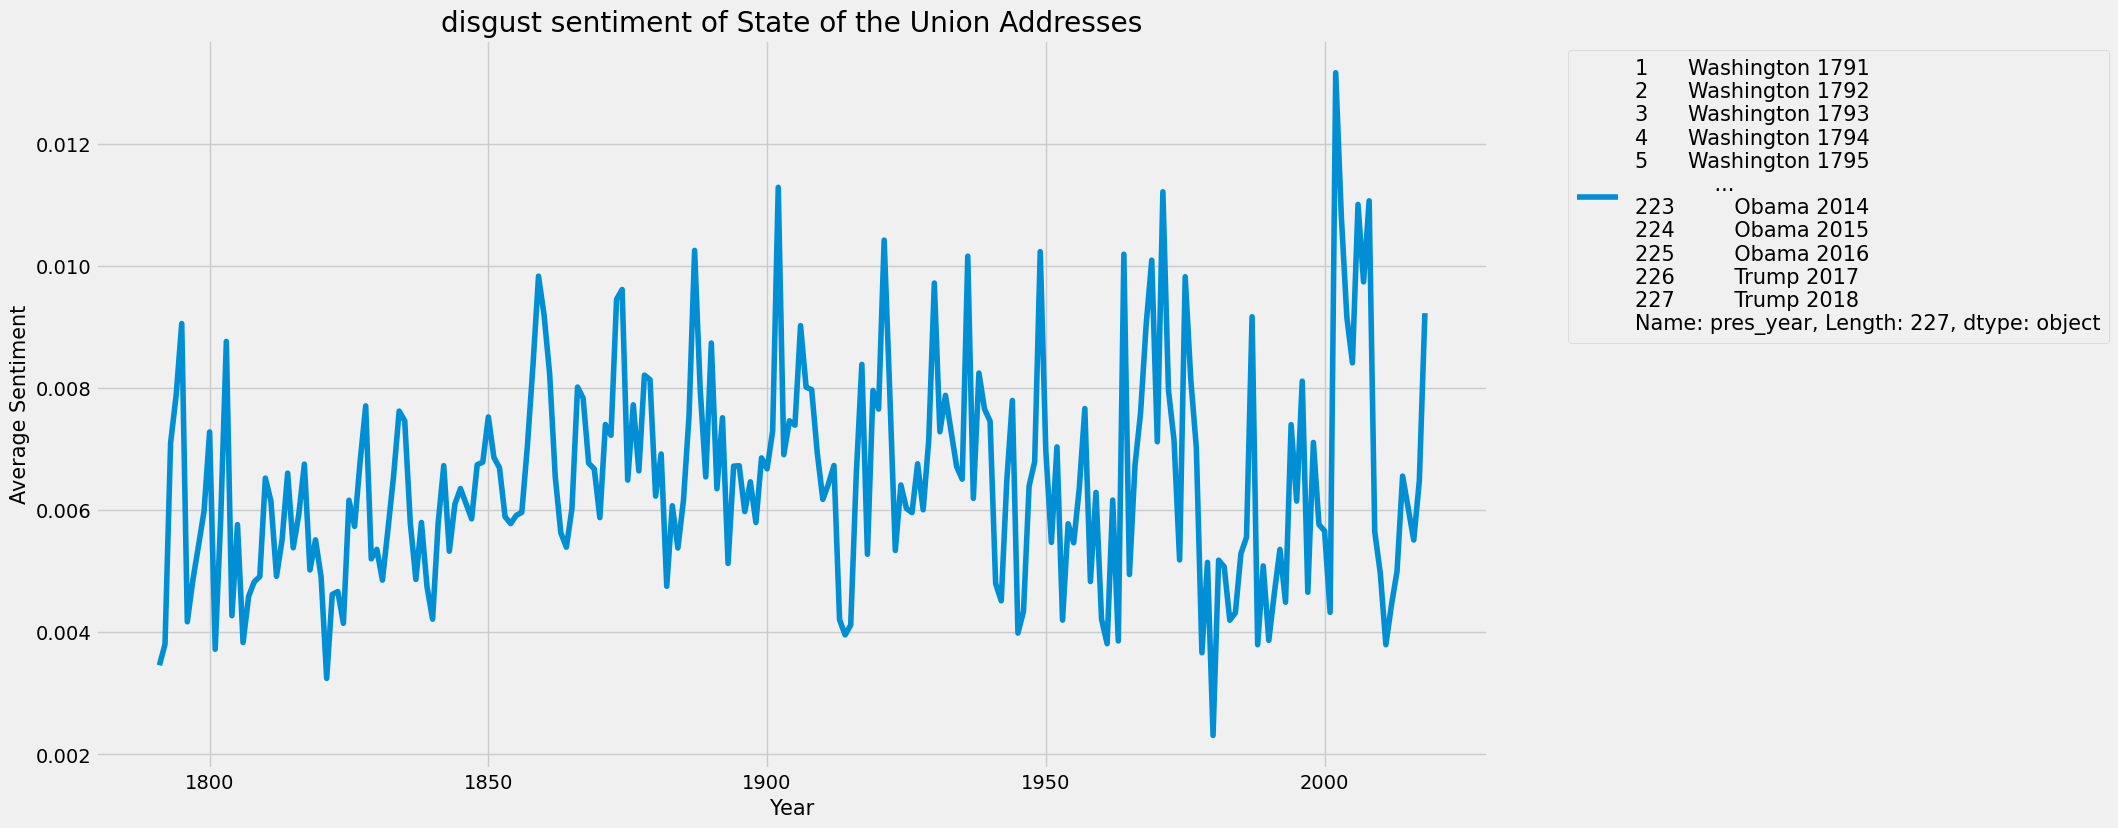

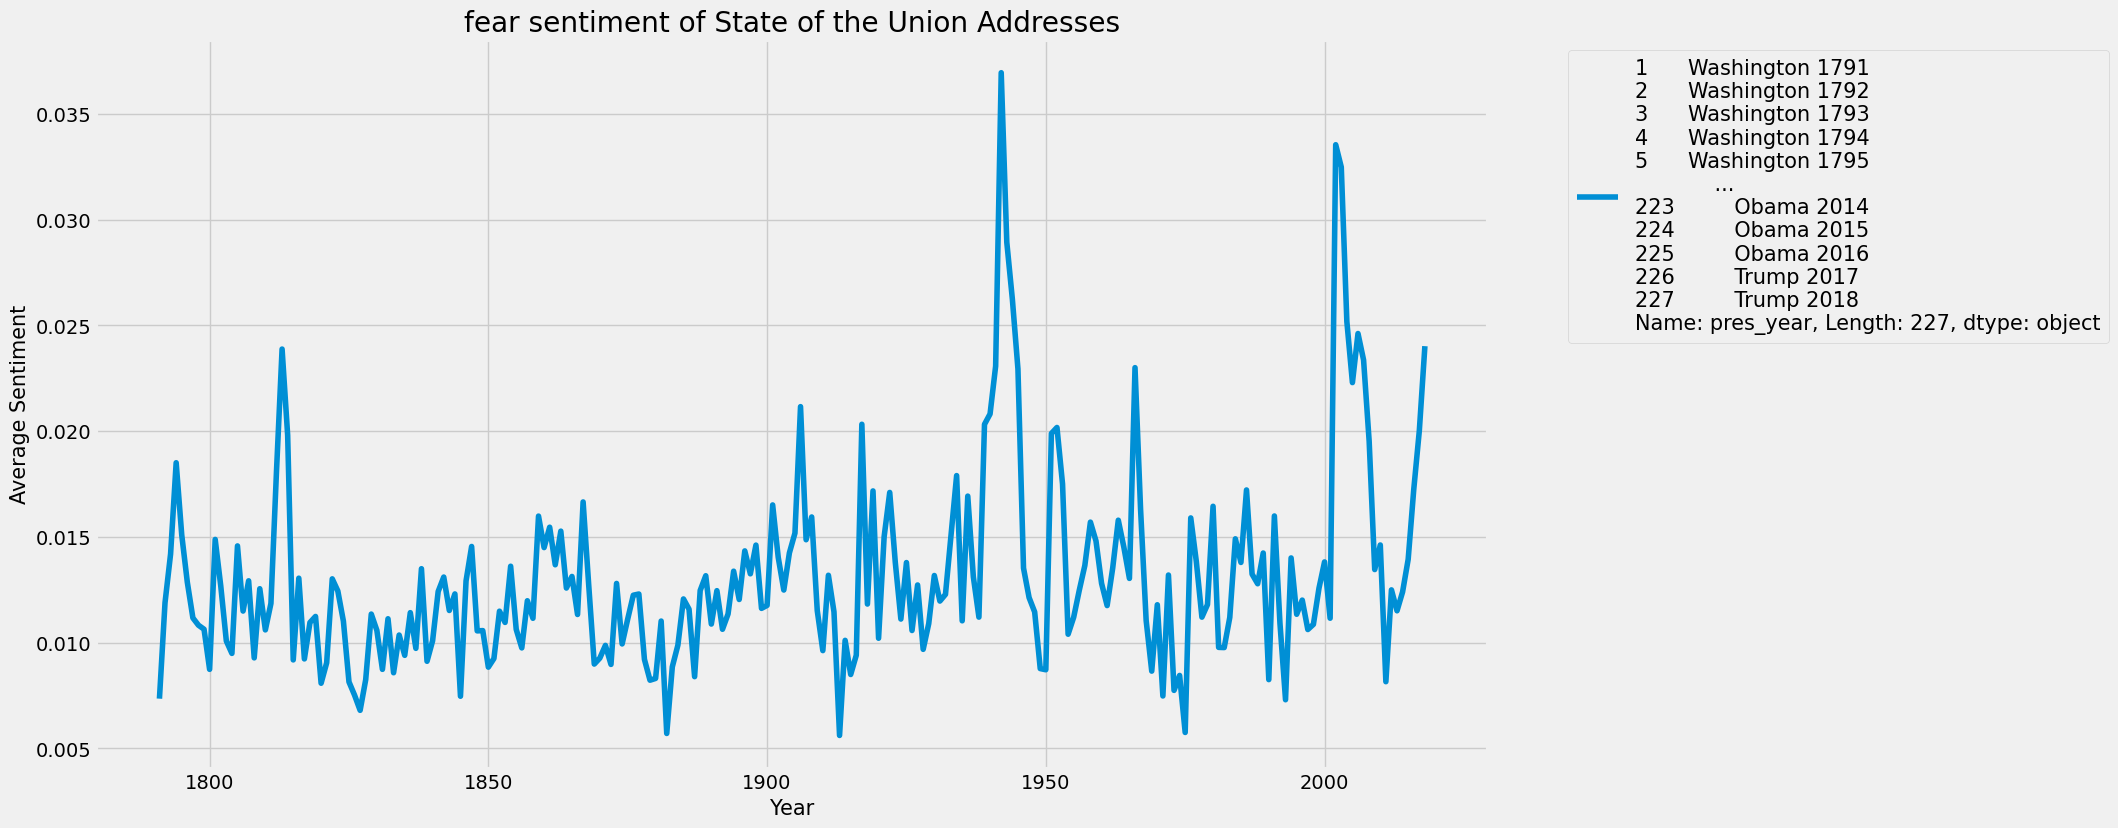

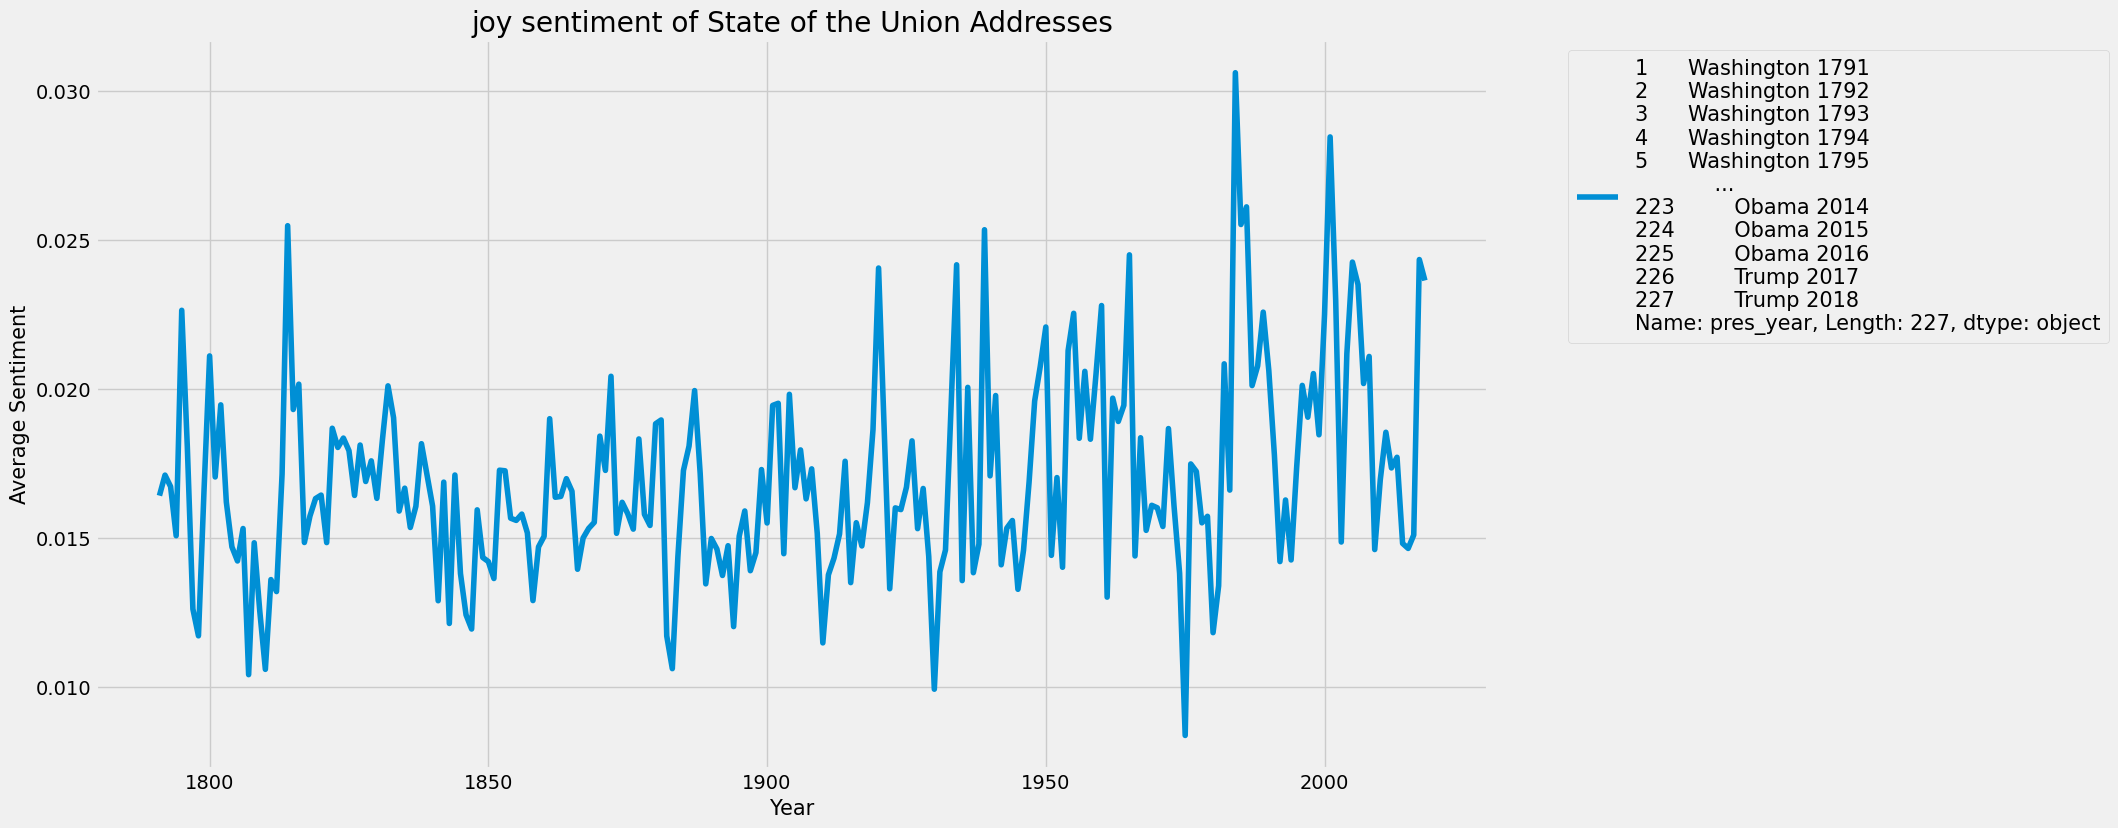

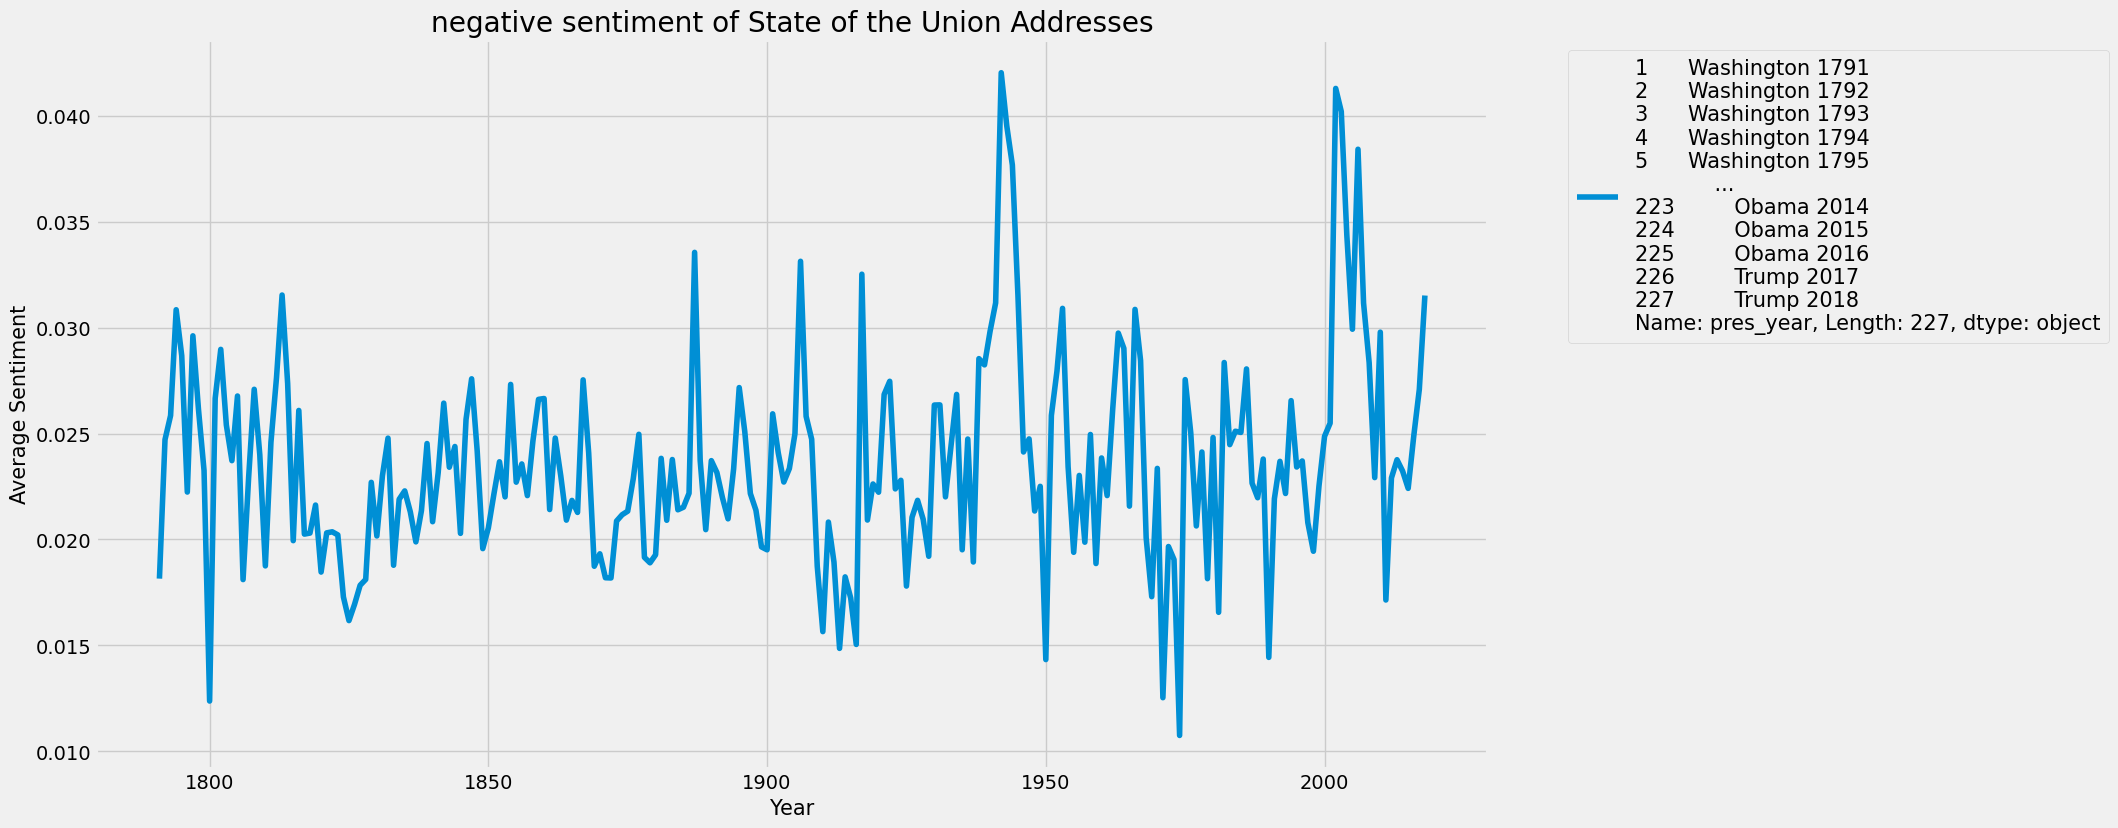

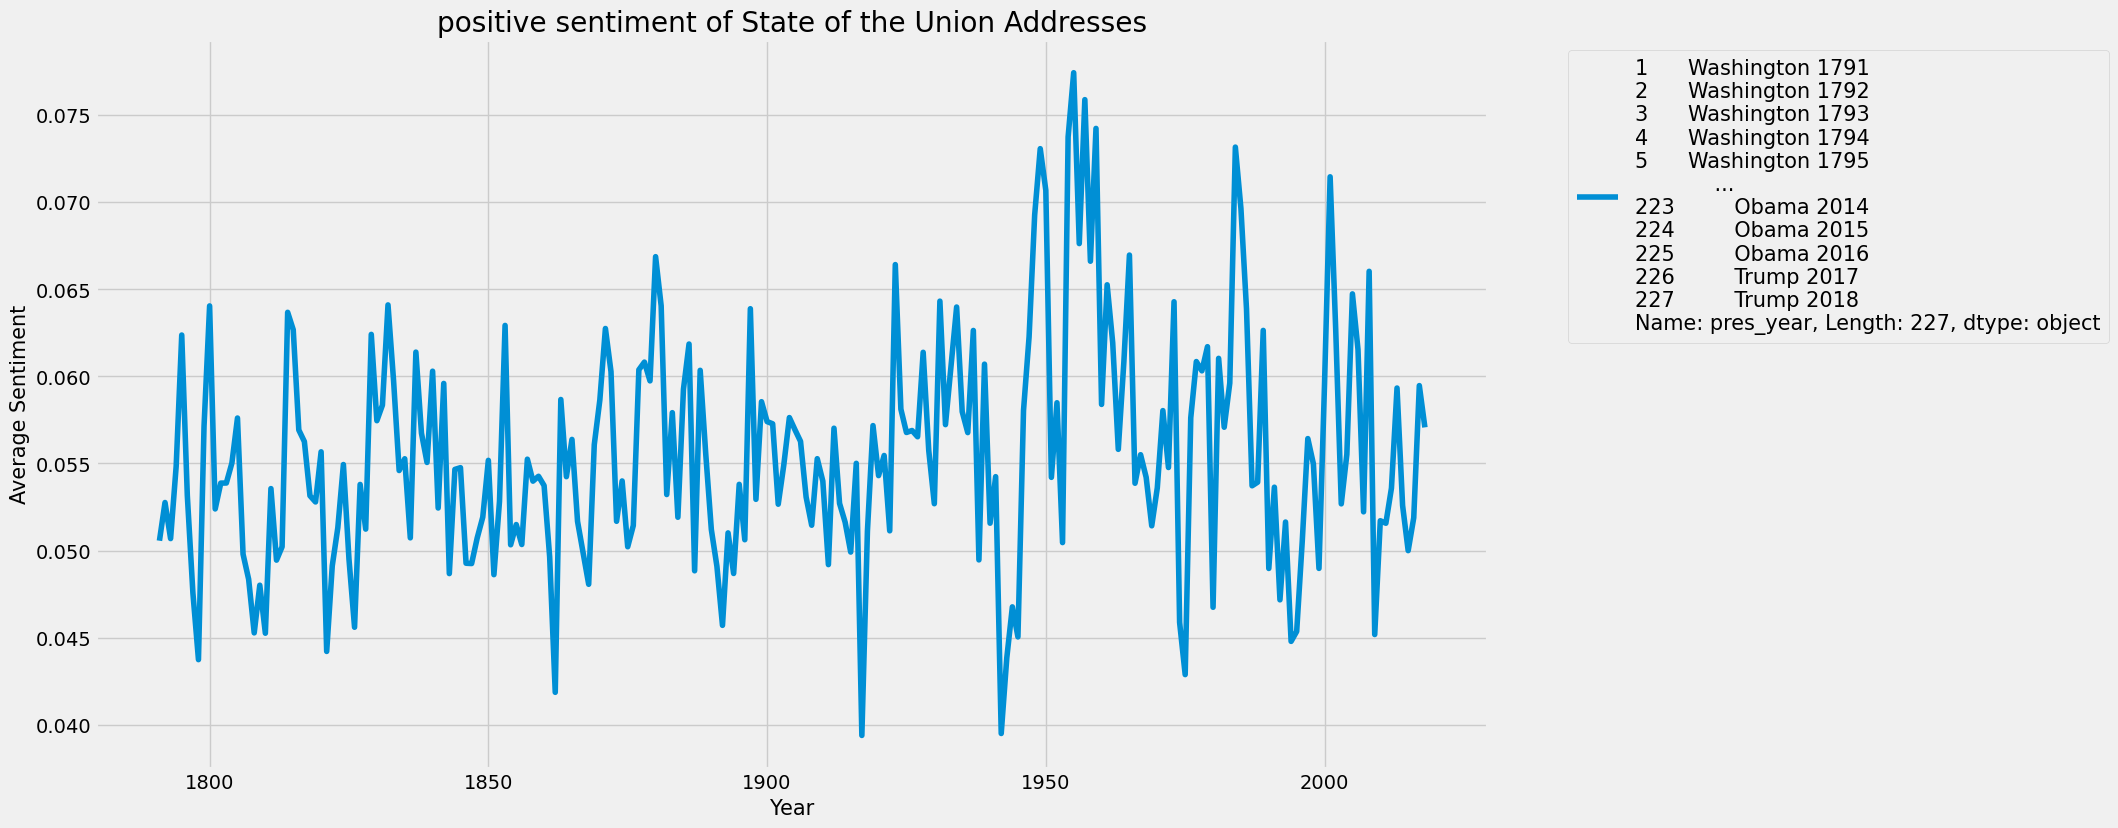

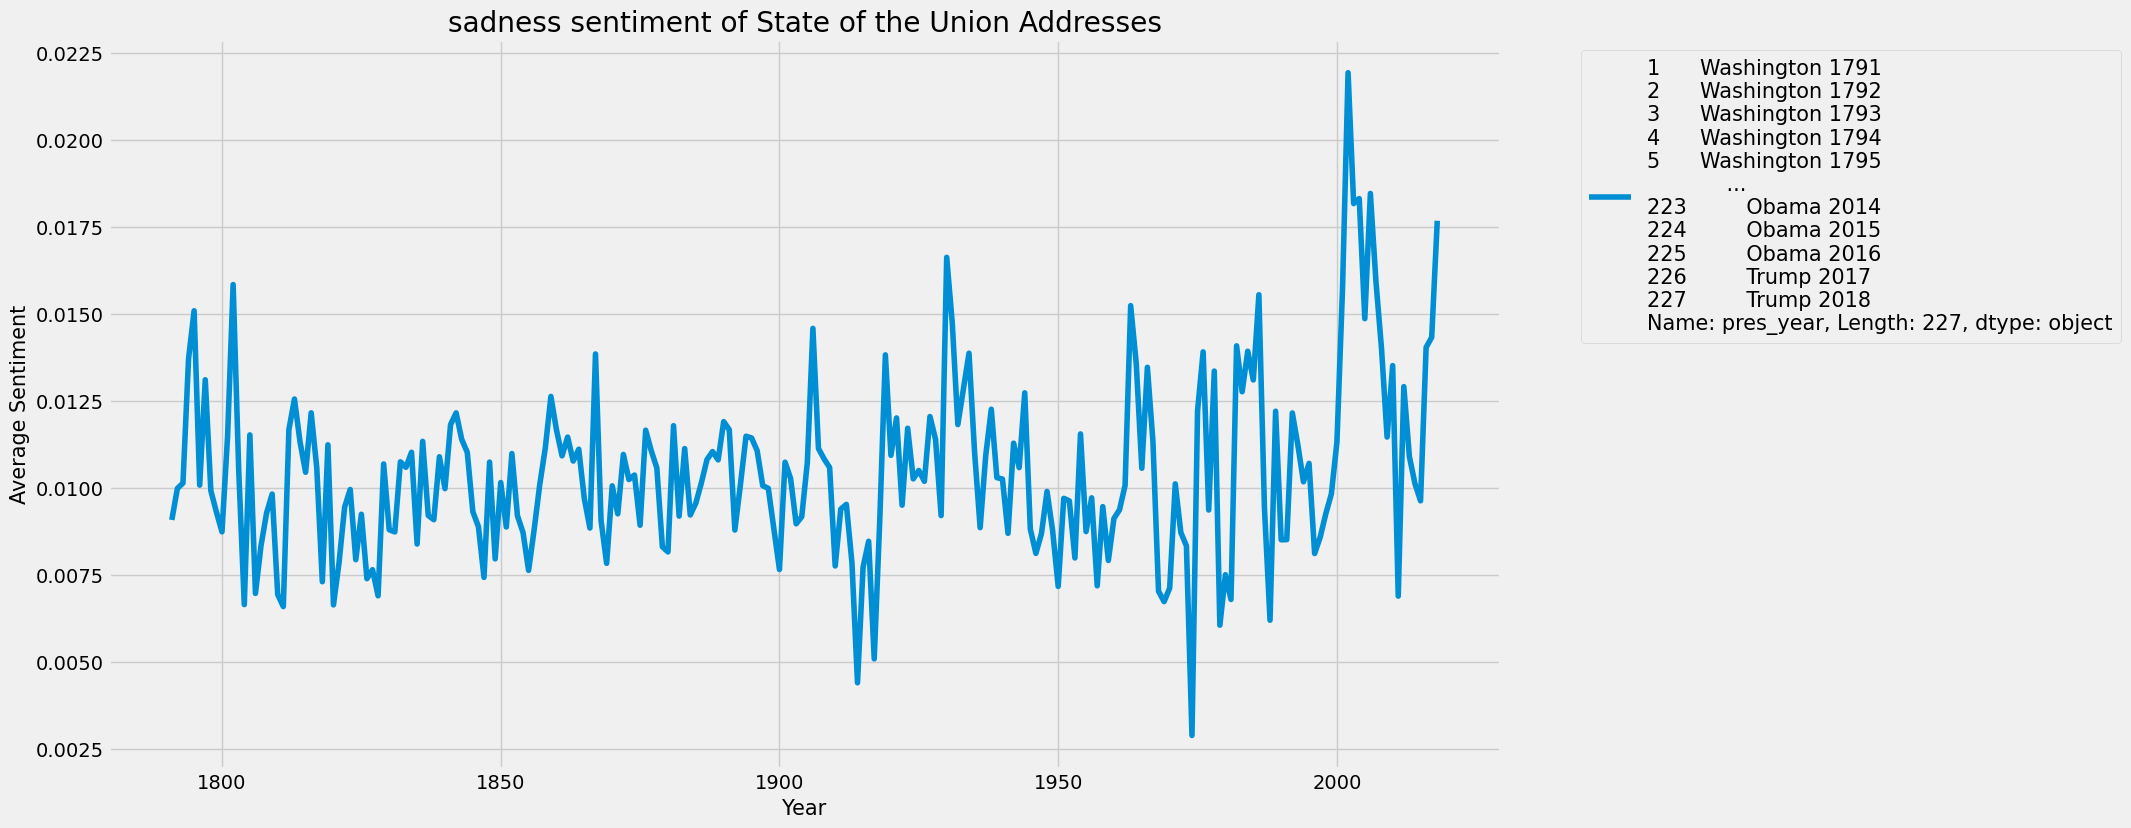

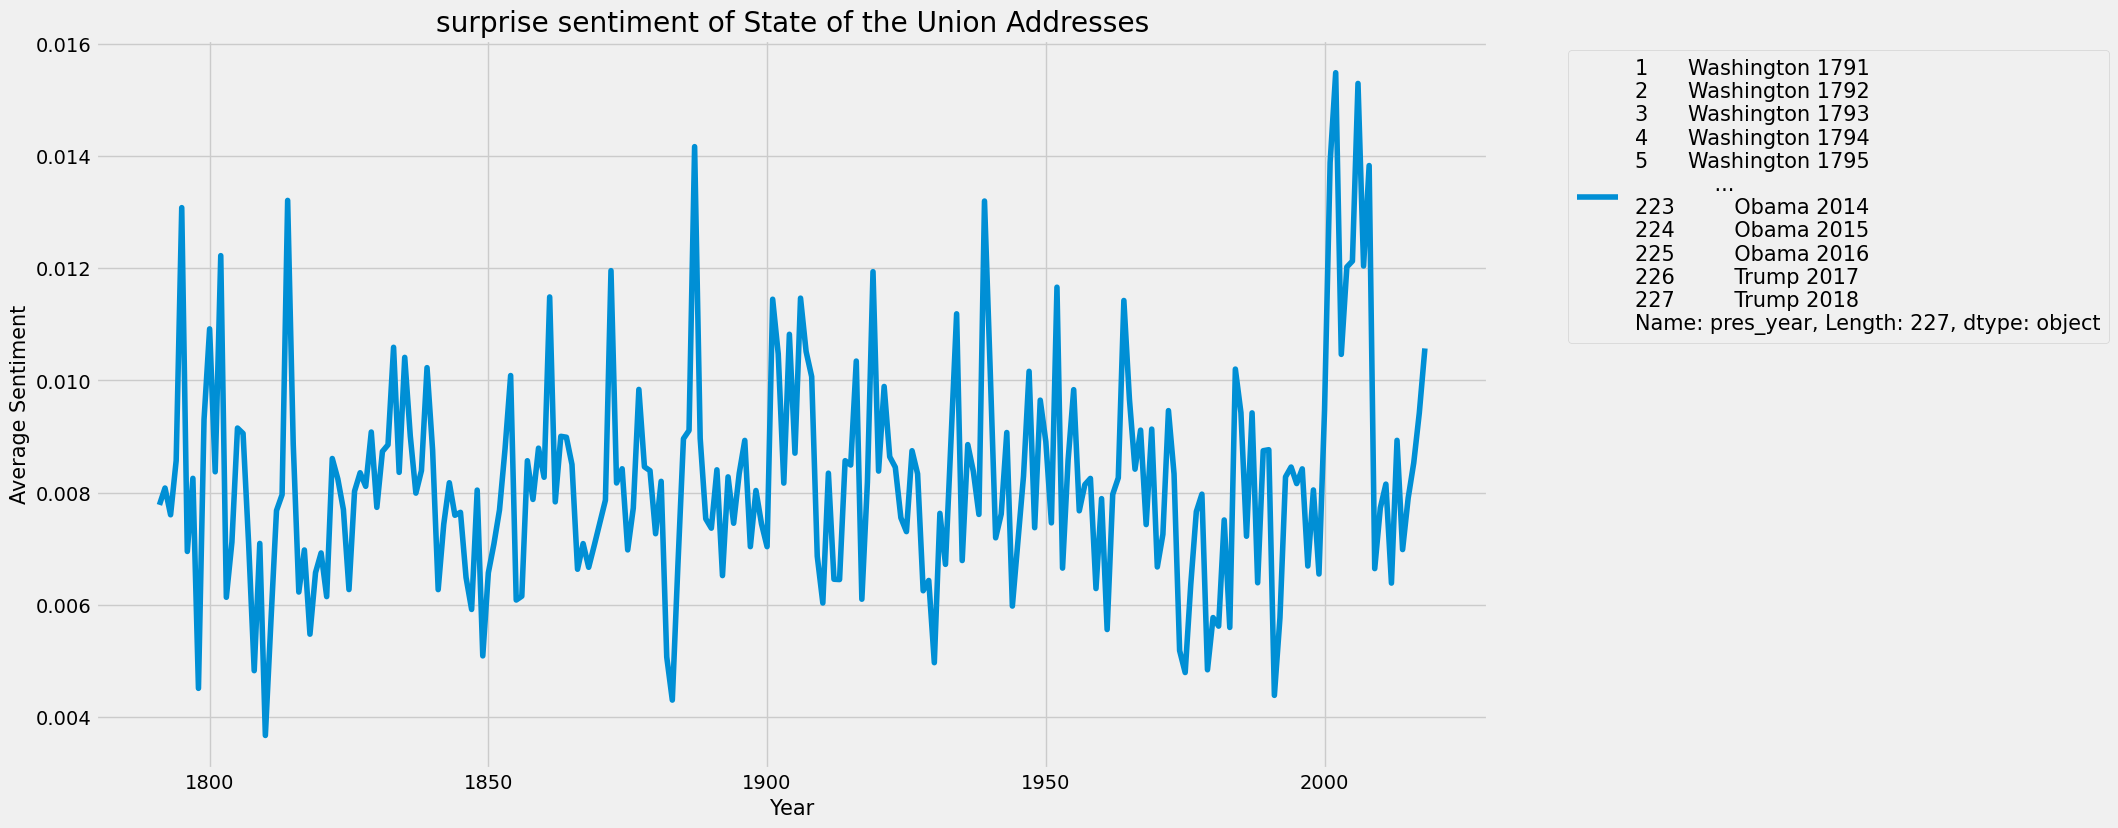

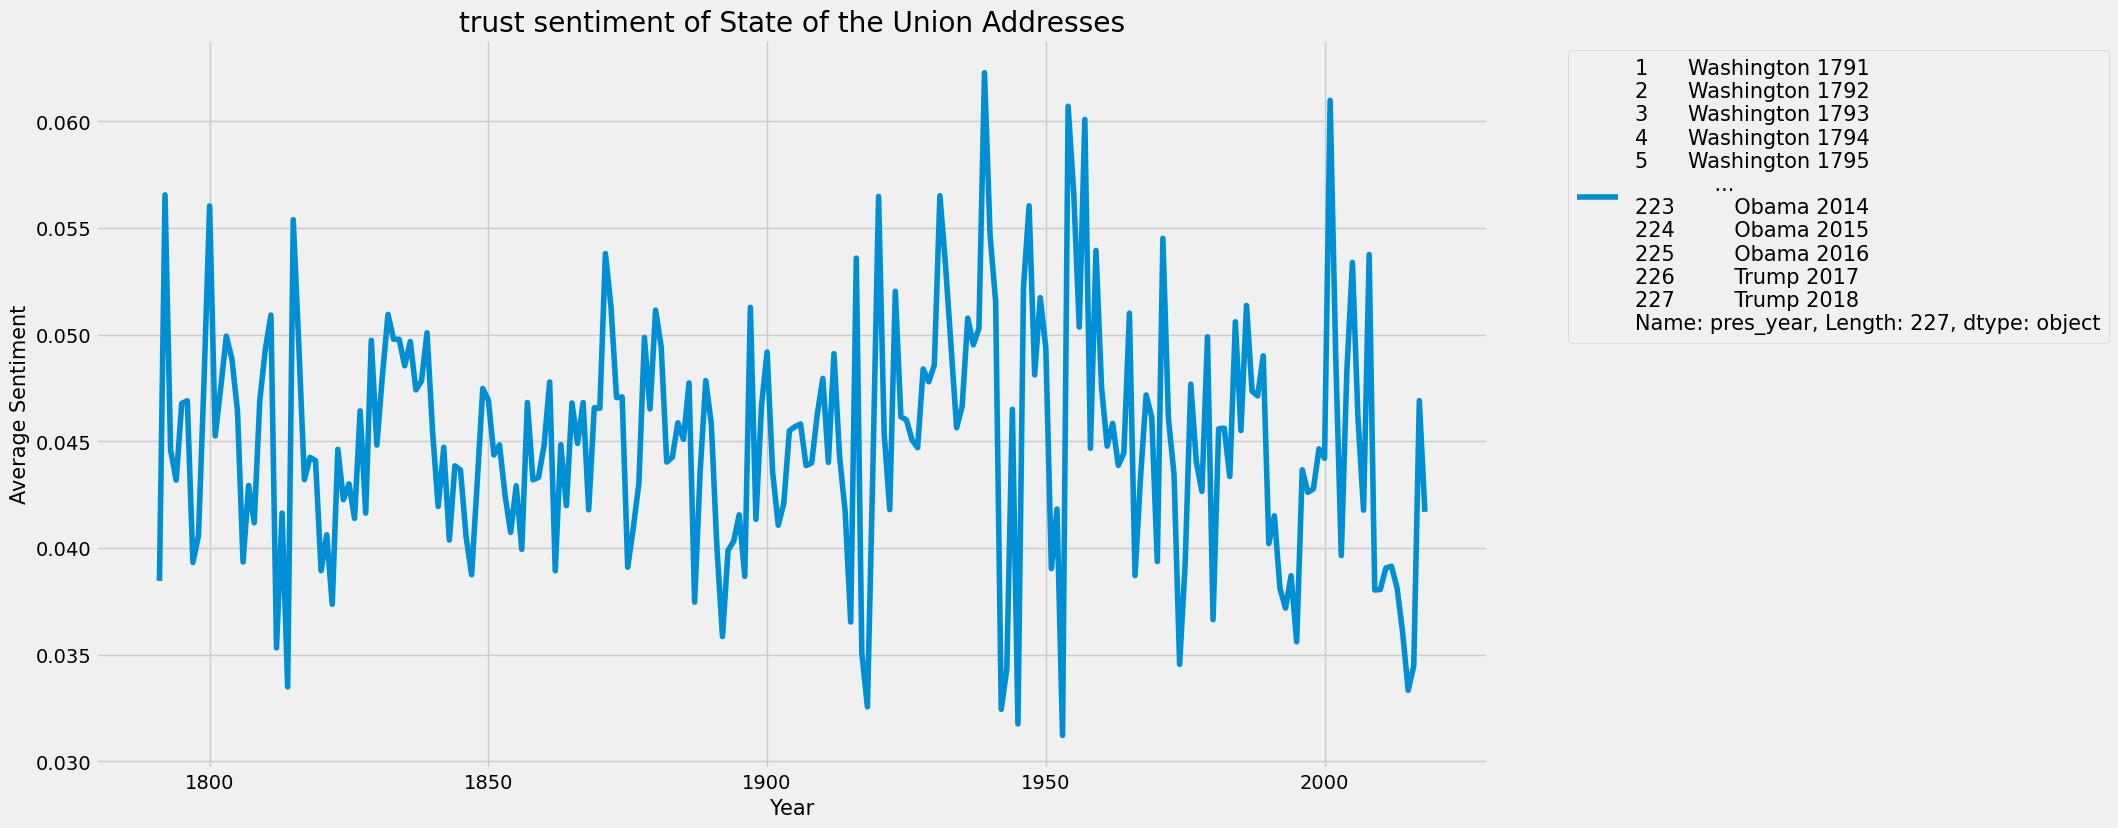

In [24]:
sotunrc2['pres_year'] = sotunrc2['pres']  + " " + sotunrc2['year'].astype(str)
# length = sum([len(sotudf3['word_count'])])
x = sotunrc2['year'].tolist()
for emotion in emotions:
    y = sotunrc2[emotion]
    plt.plot(x,y,label = sotunrc2['pres_year'])
    plt.title('{} sentiment of State of the Union Addresses'.format(emotion, fontsize=24))
    plt.xlabel('Year', fontsize=15)
    plt.ylabel('Average Sentiment', fontsize=15)
    plt.legend(loc='best', fontsize=15, bbox_to_anchor=(1.05, 1))
    plt.show()

In [29]:
sotunrc2["presnum"] = (sotunrc2["pres"] != sotunrc2["pres"].shift()).cumsum()
presdf = sotunrc2[["pres","year","presnum","pres_year"]]
presdf.to_csv("pres_sotulist.csv",encoding='utf-8')
presyears = presdf.groupby('presnum')['year'].apply(list)
print(presyears[-10:])

presnum
34                [1964, 1965, 1966, 1967, 1968, 1969]
35                      [1970, 1971, 1972, 1973, 1974]
36                                  [1975, 1976, 1977]
37                            [1978, 1979, 1980, 1981]
38          [1982, 1983, 1984, 1985, 1986, 1987, 1988]
39                            [1989, 1990, 1991, 1992]
40    [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000]
41    [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008]
42    [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
43                                        [2017, 2018]
Name: year, dtype: object


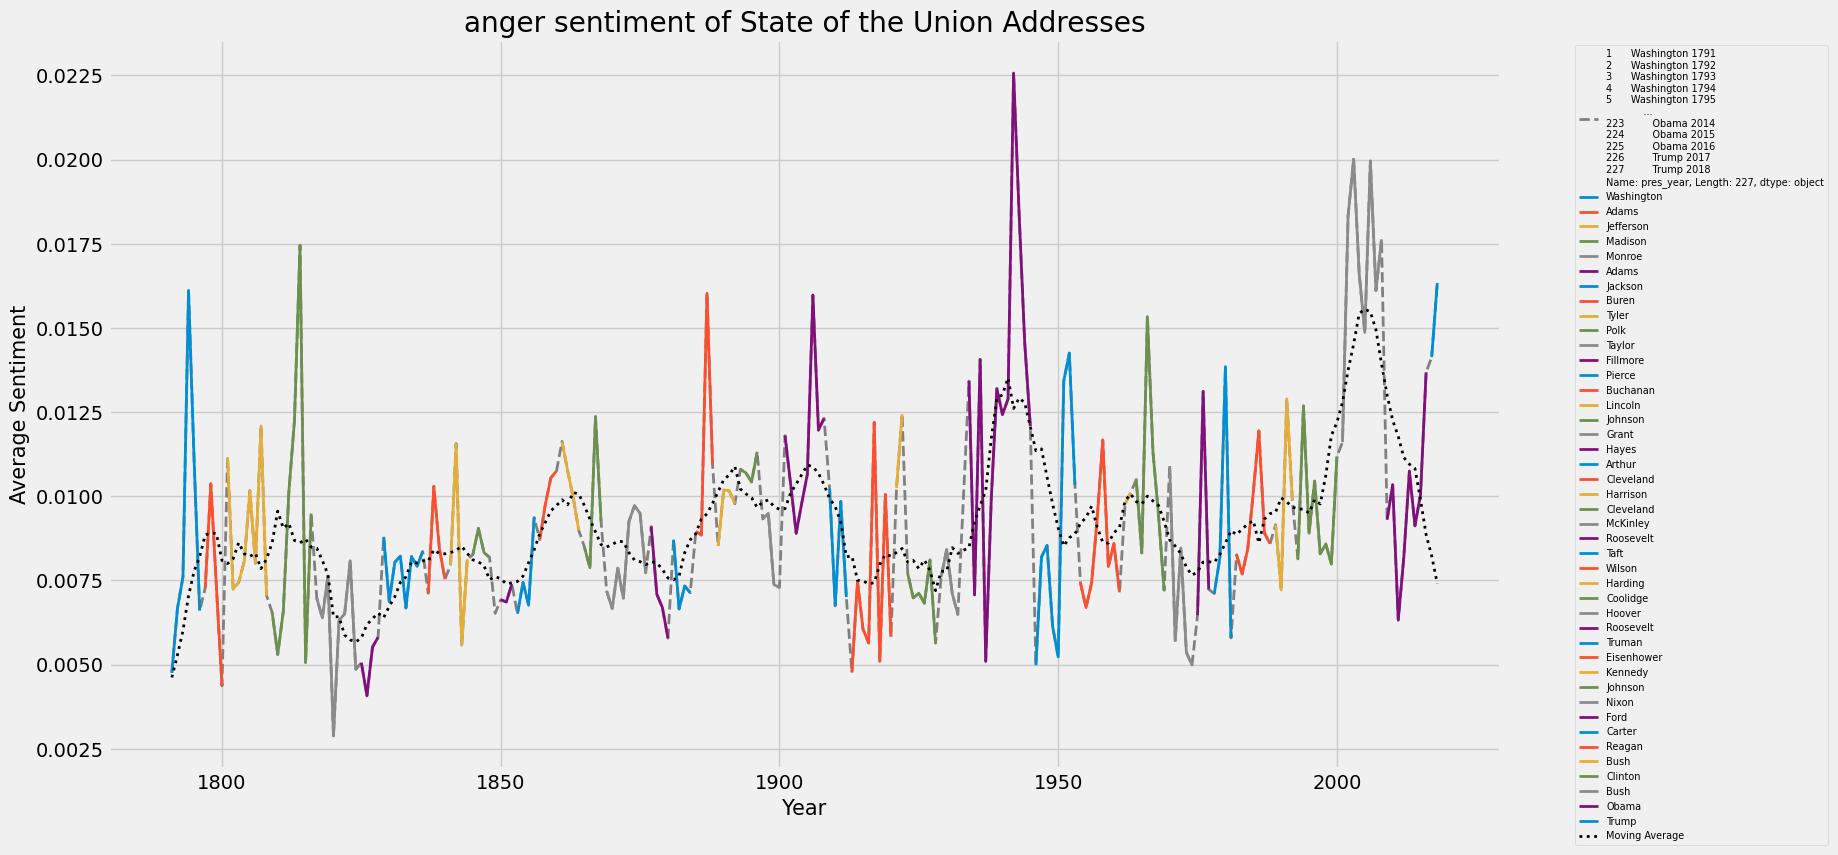

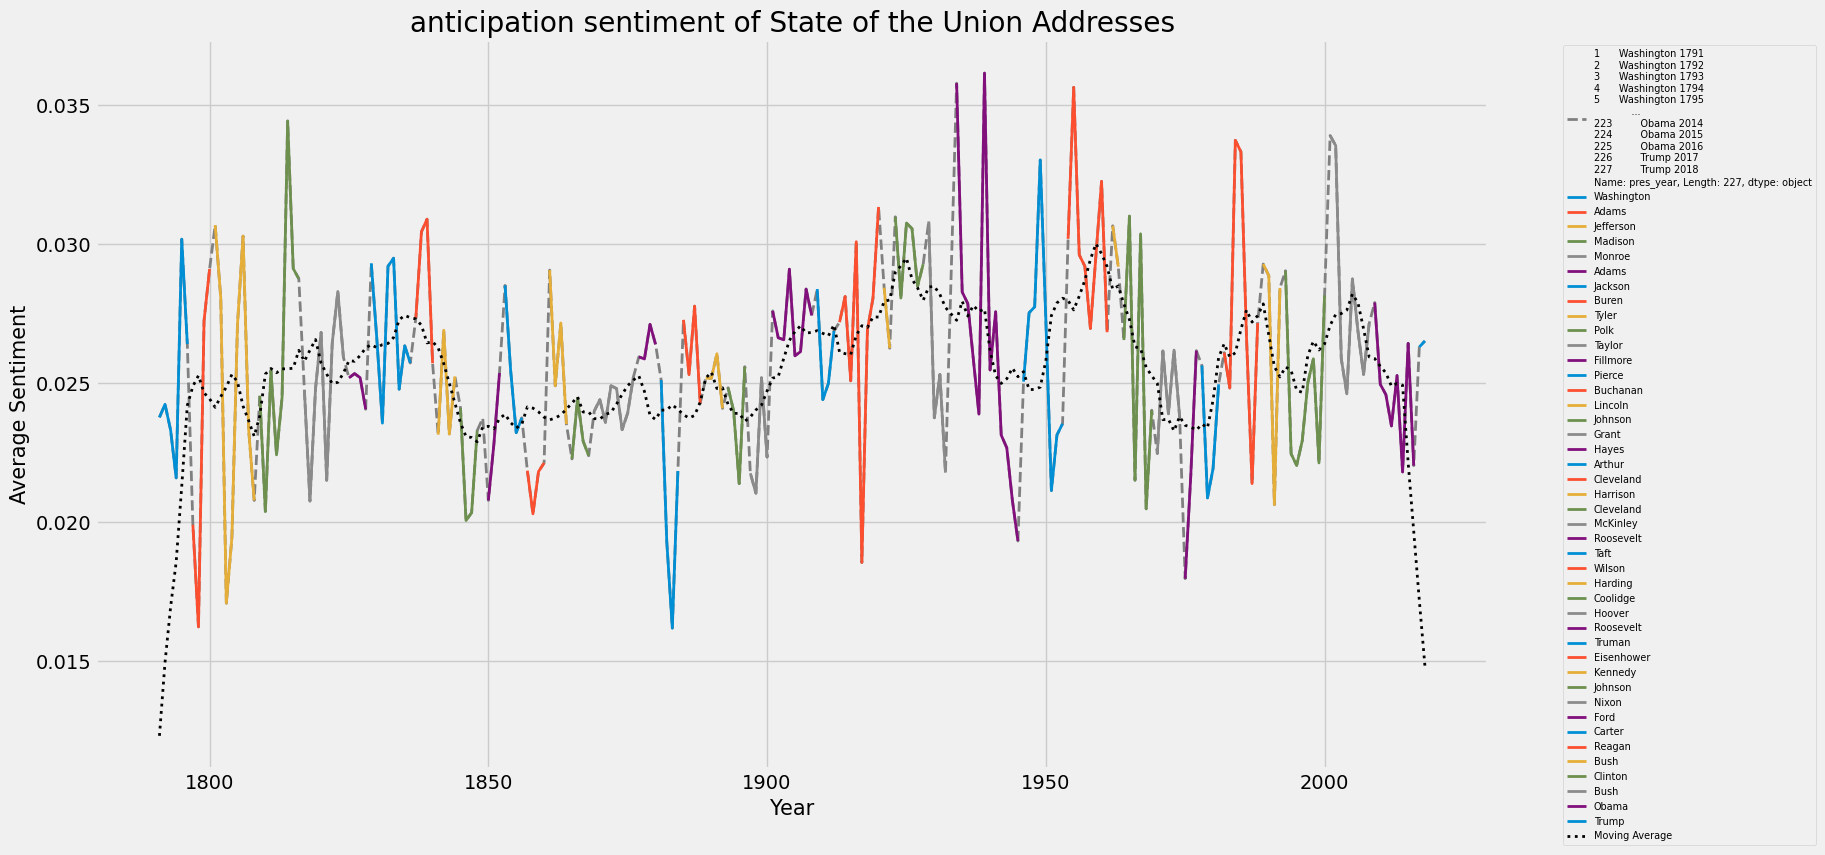

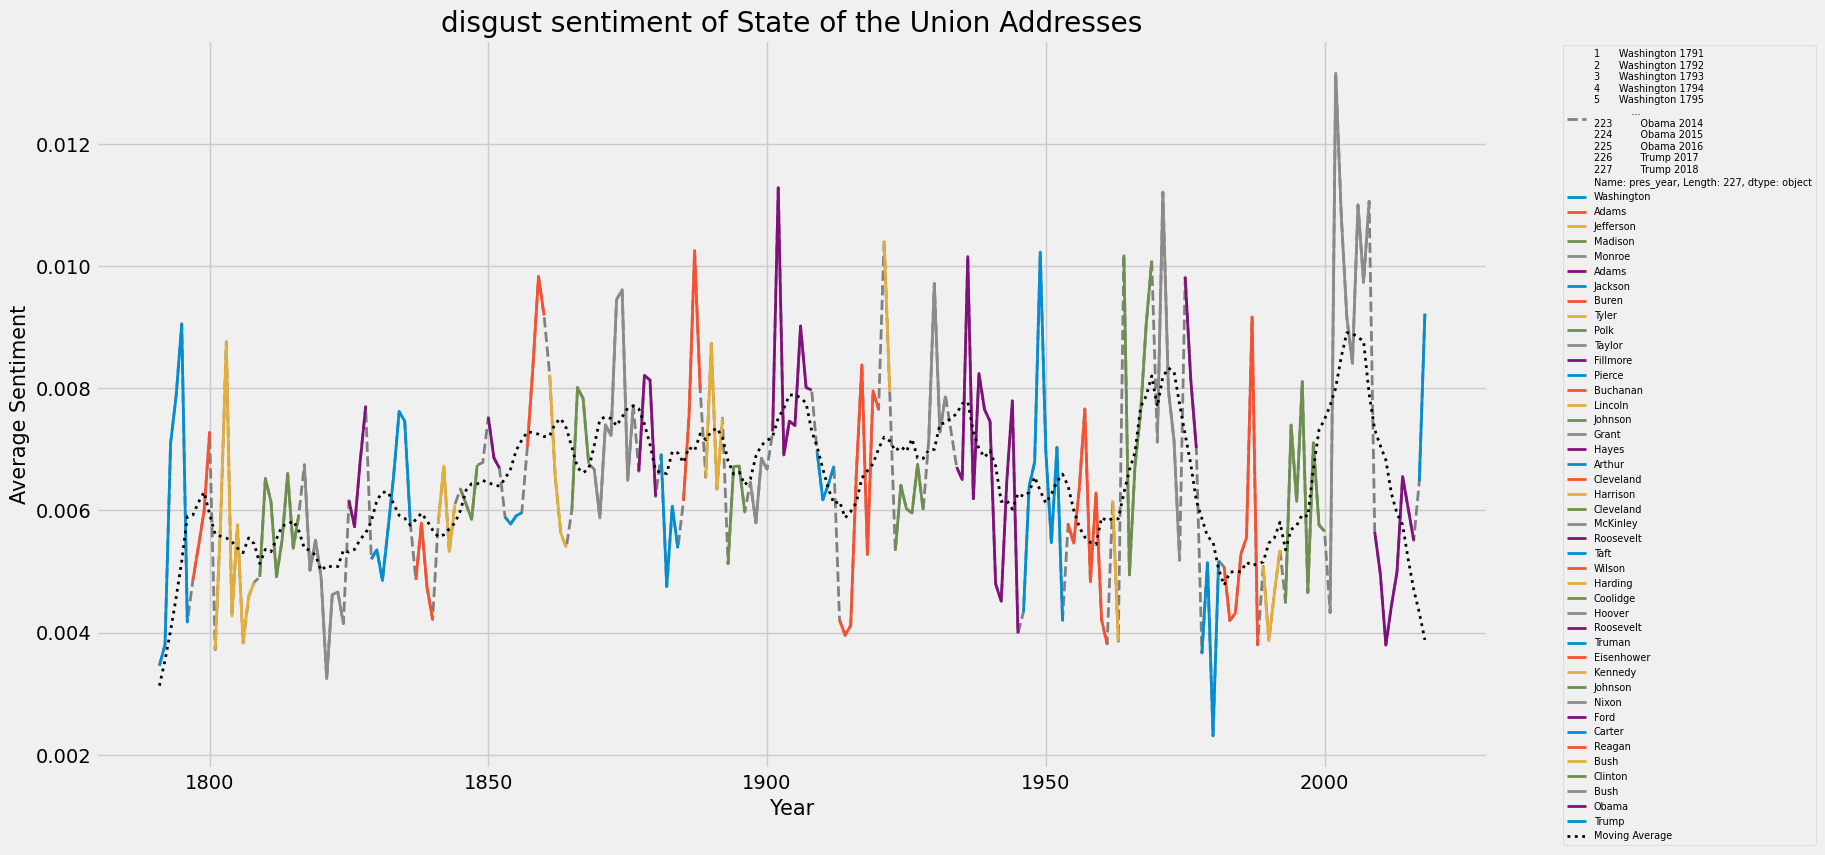

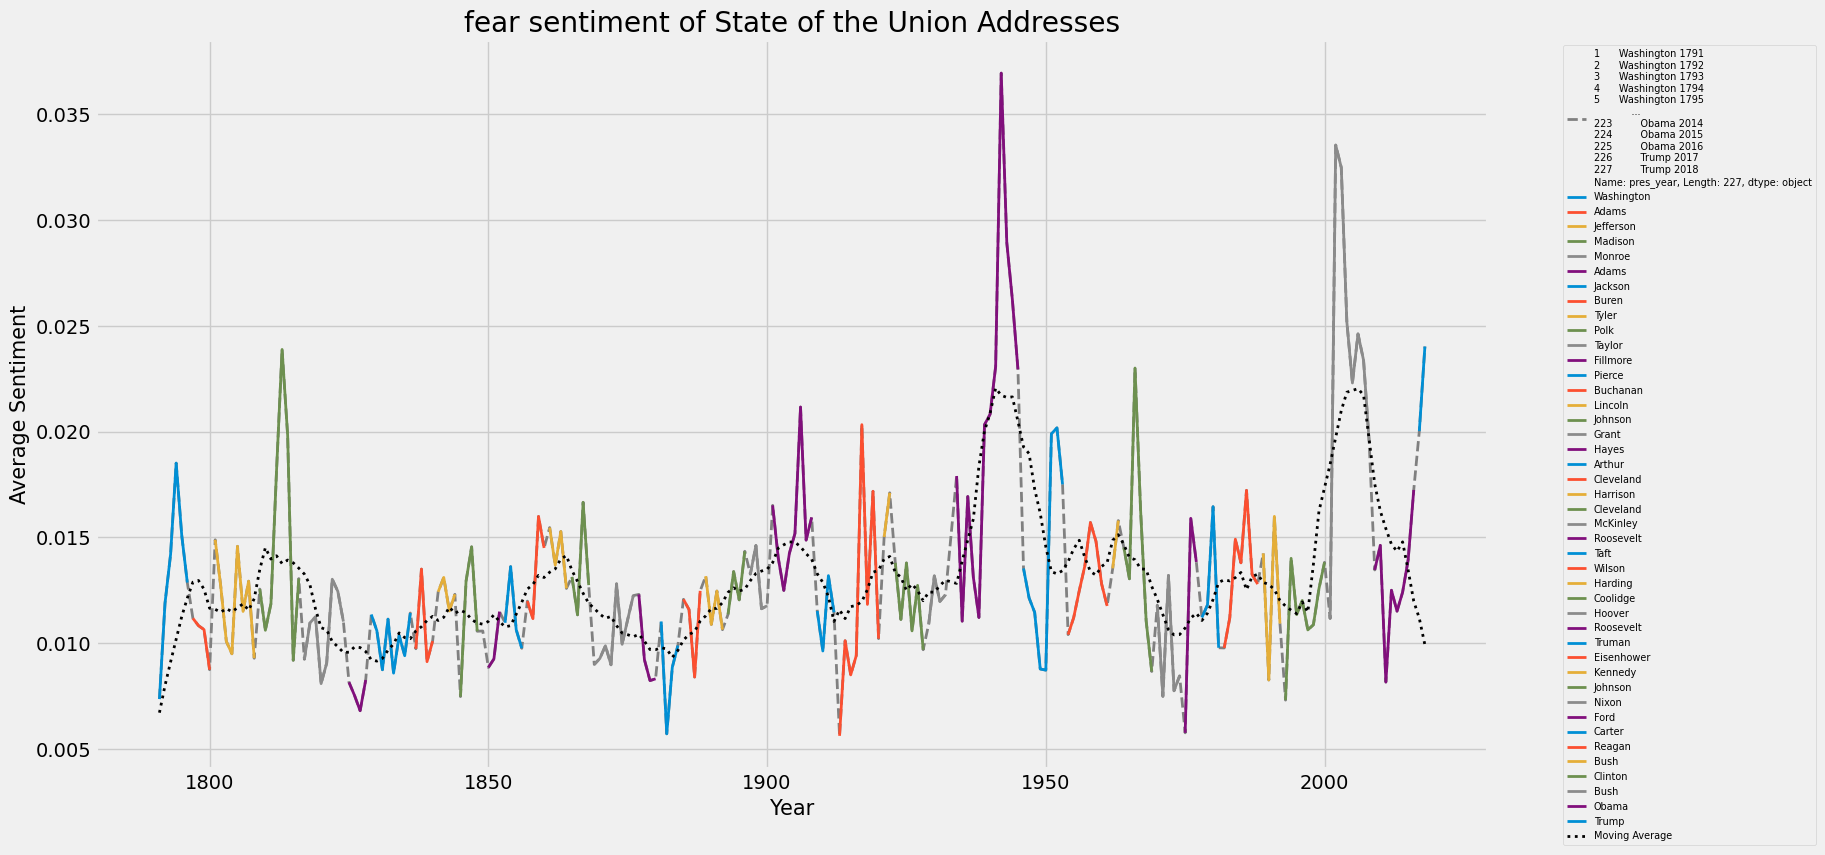

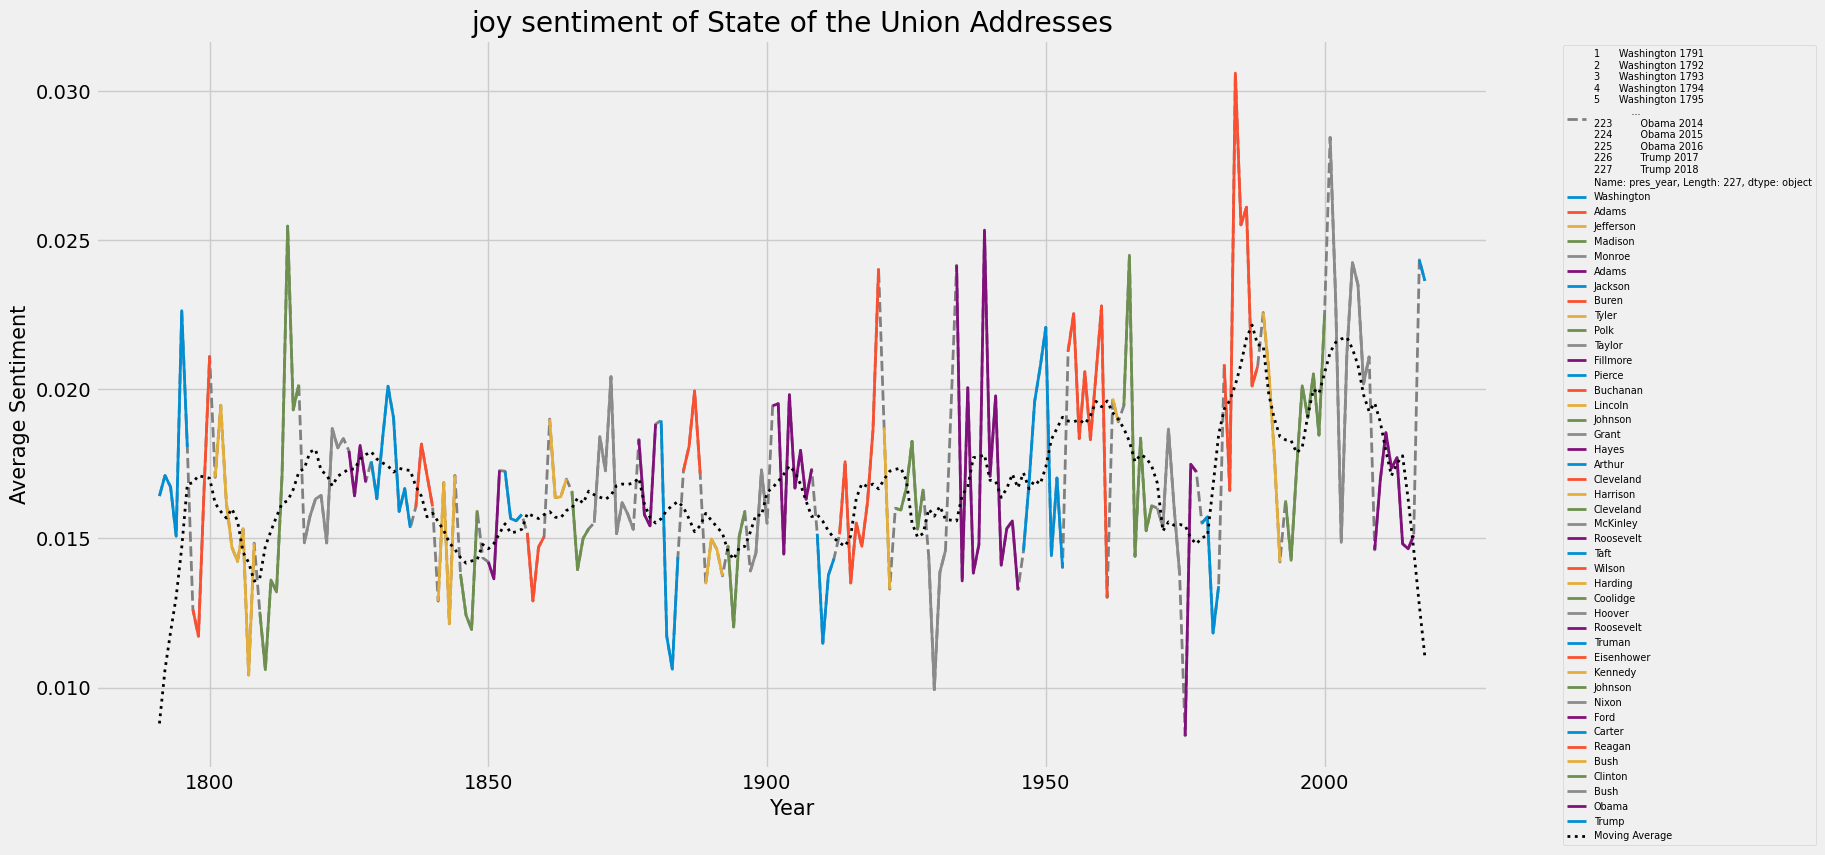

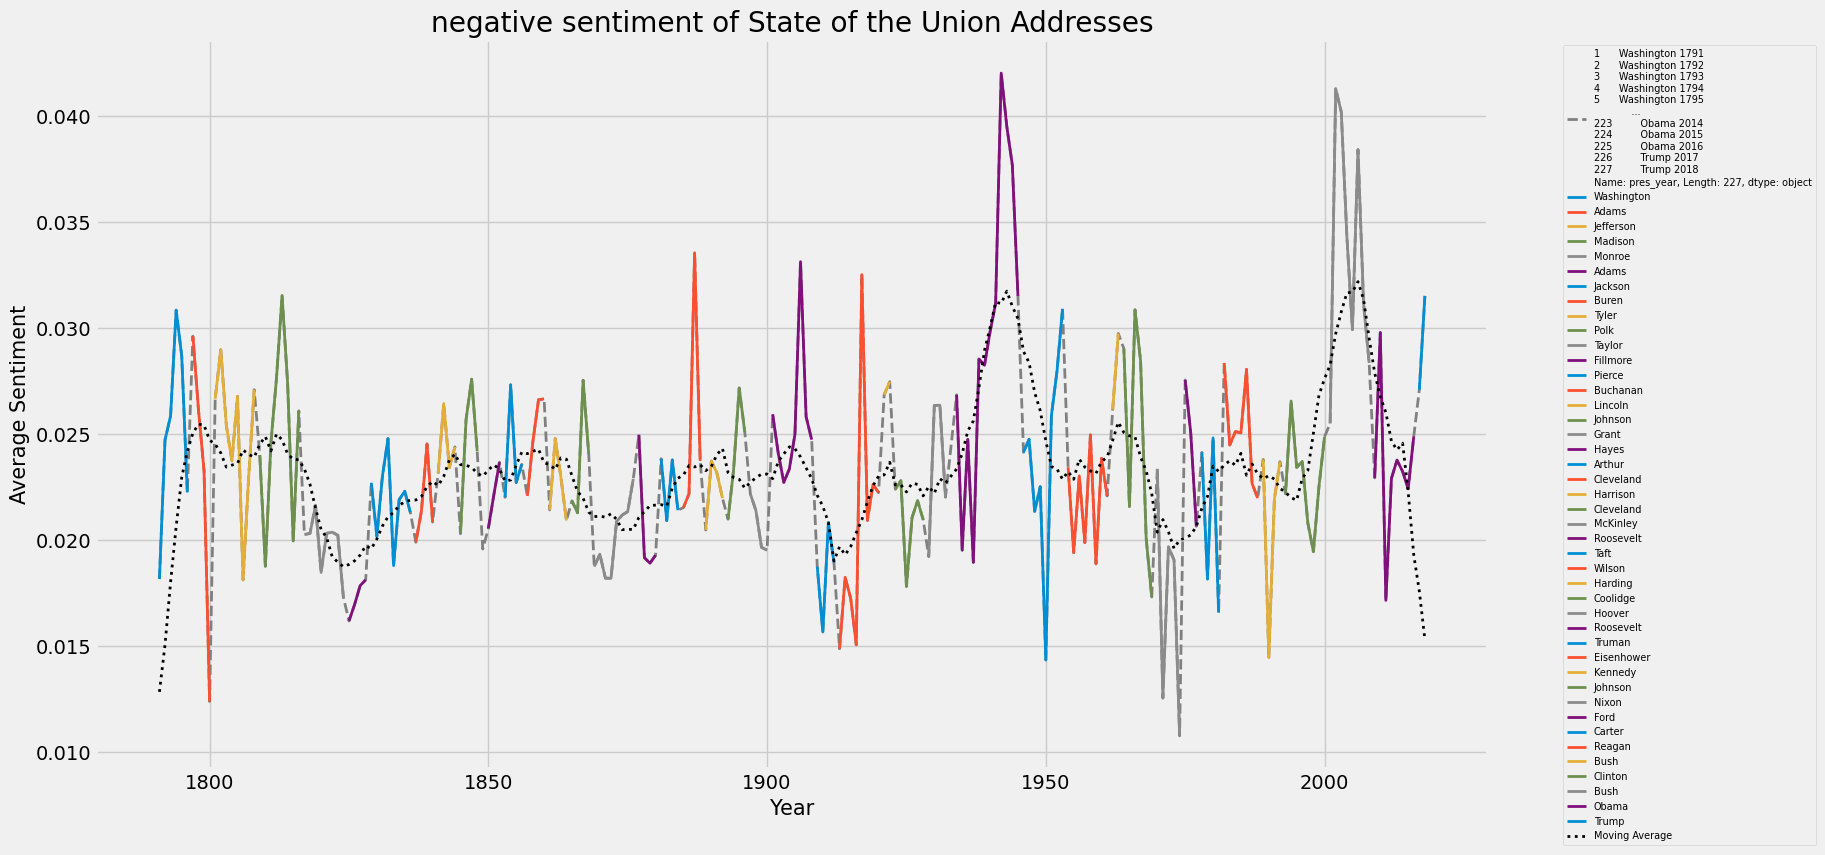

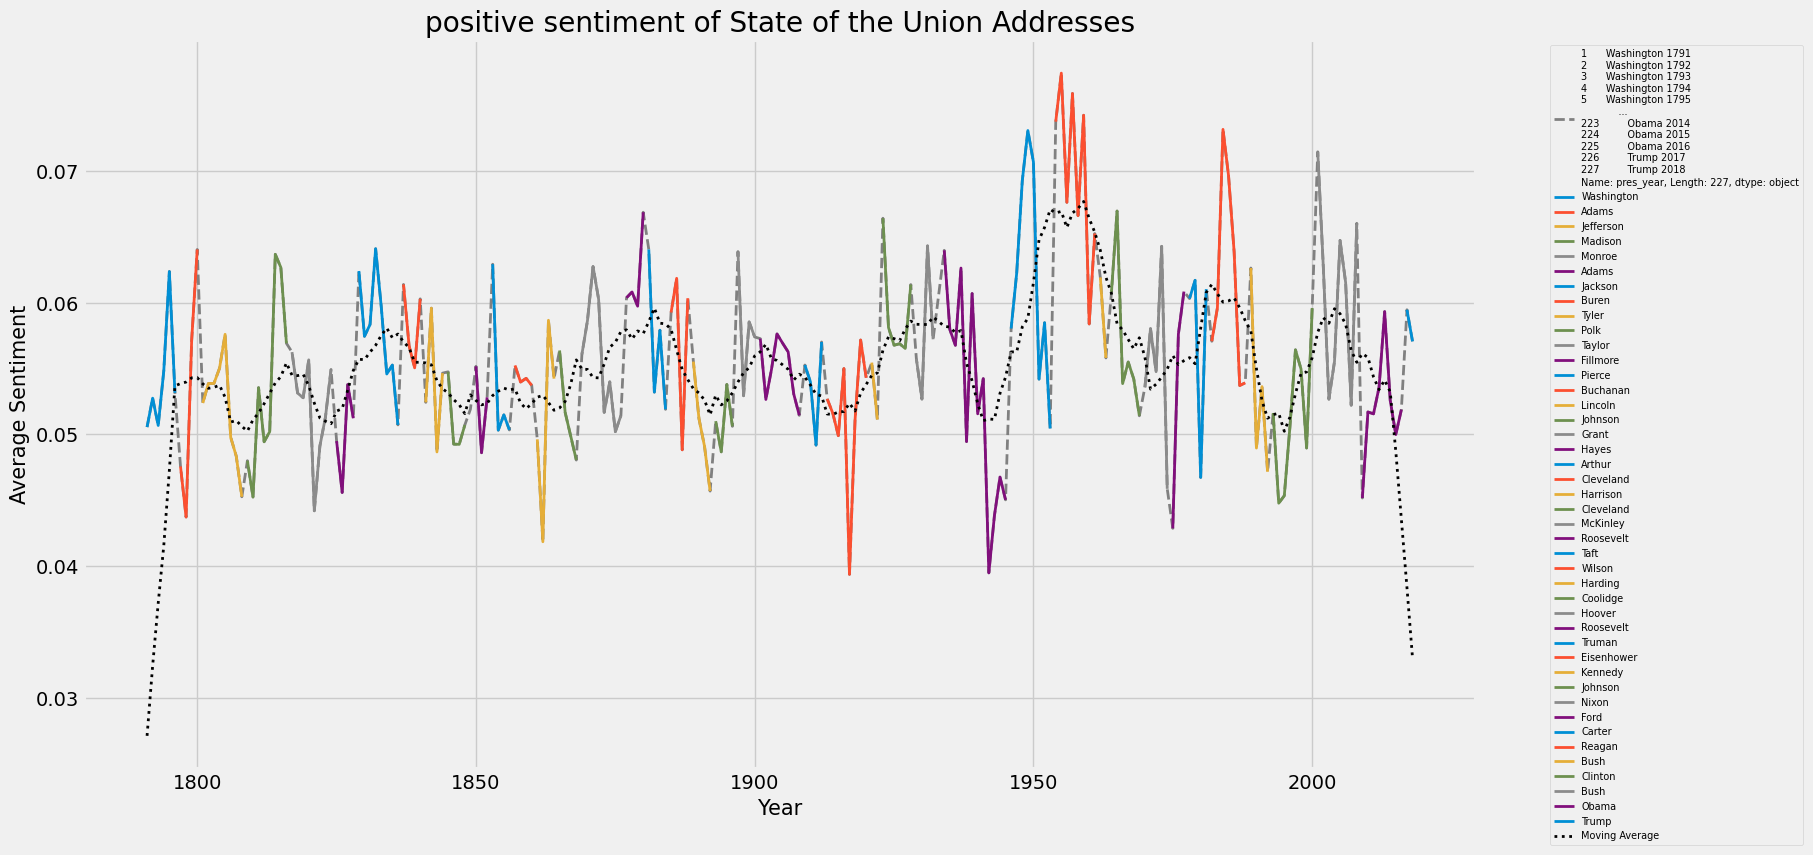

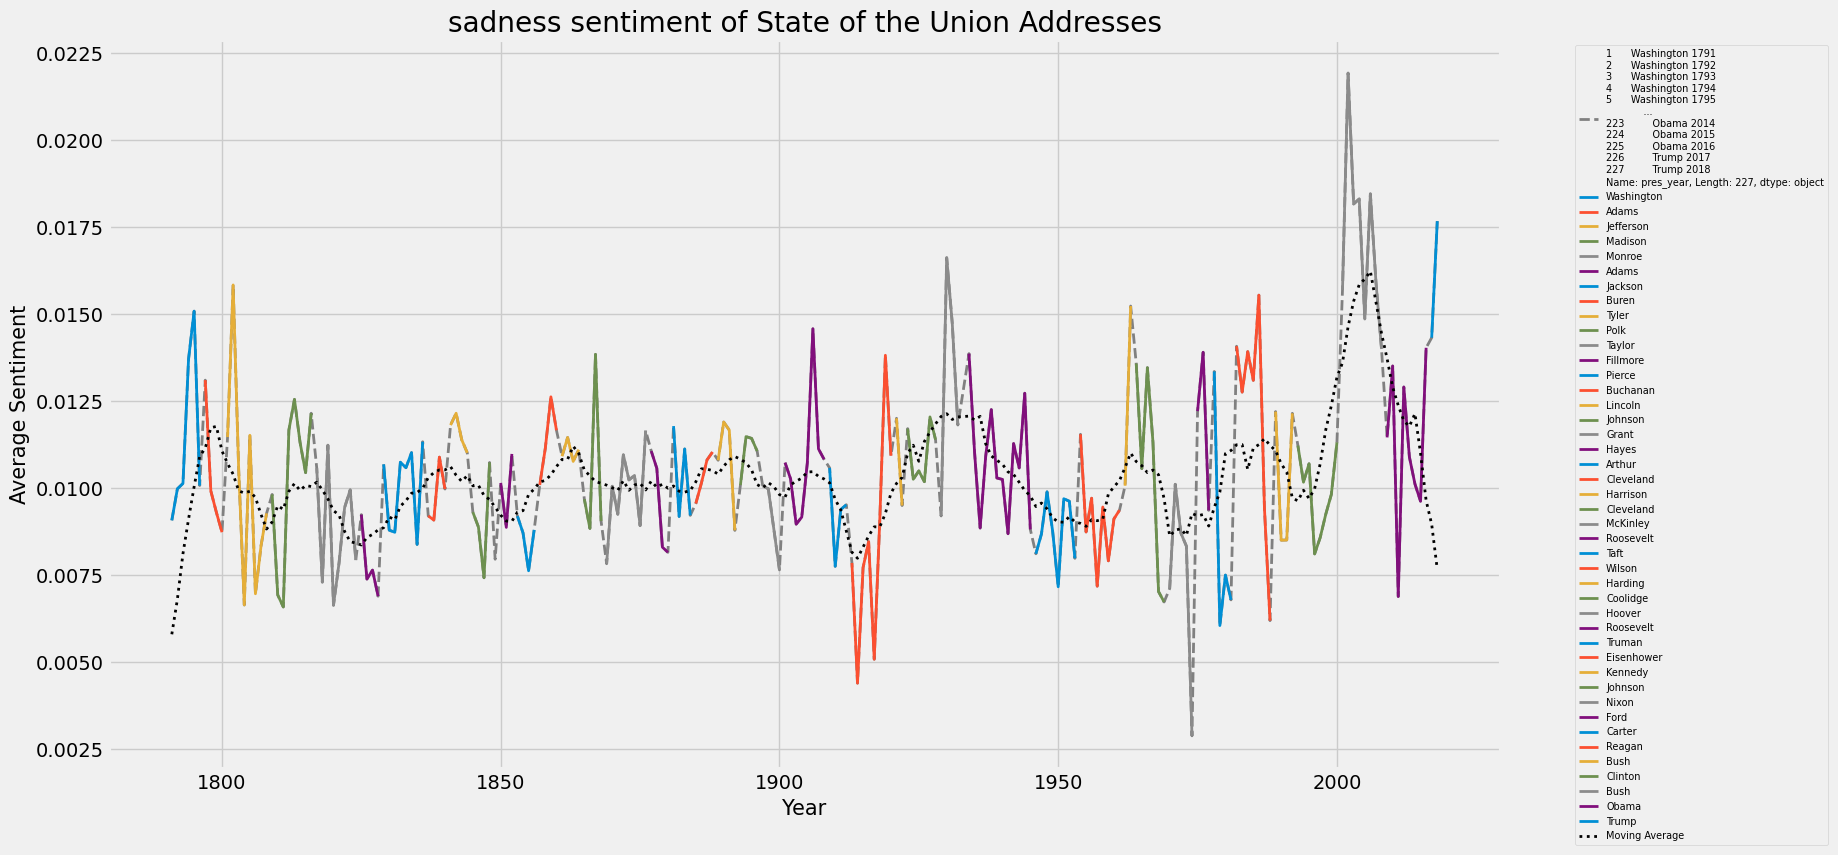

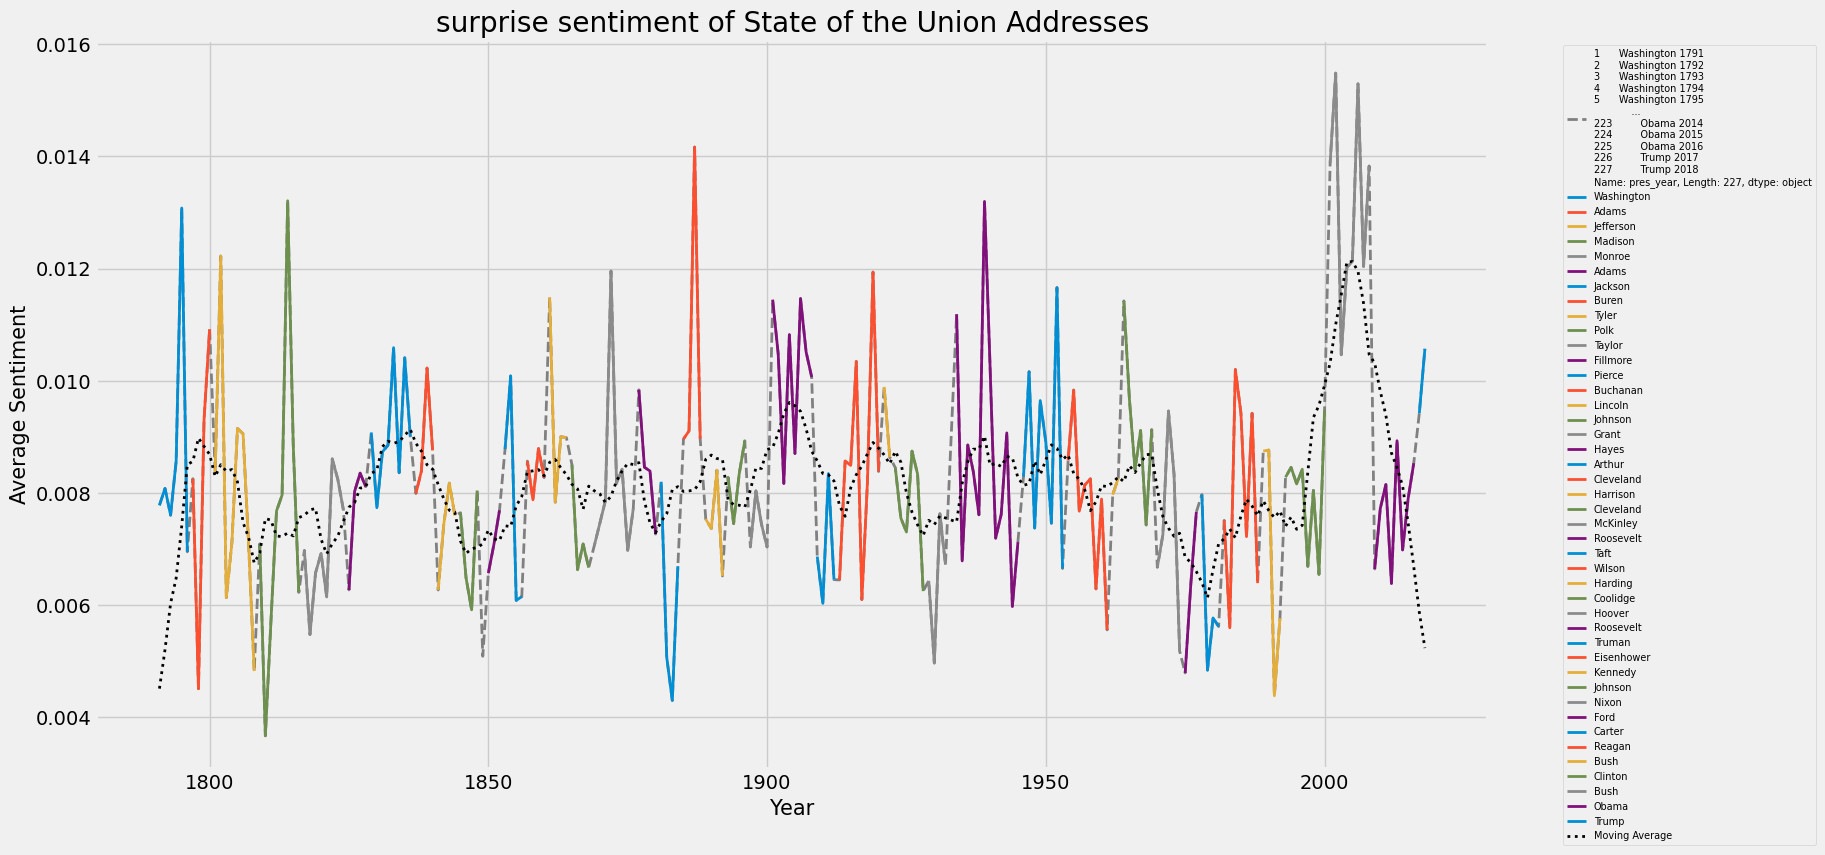

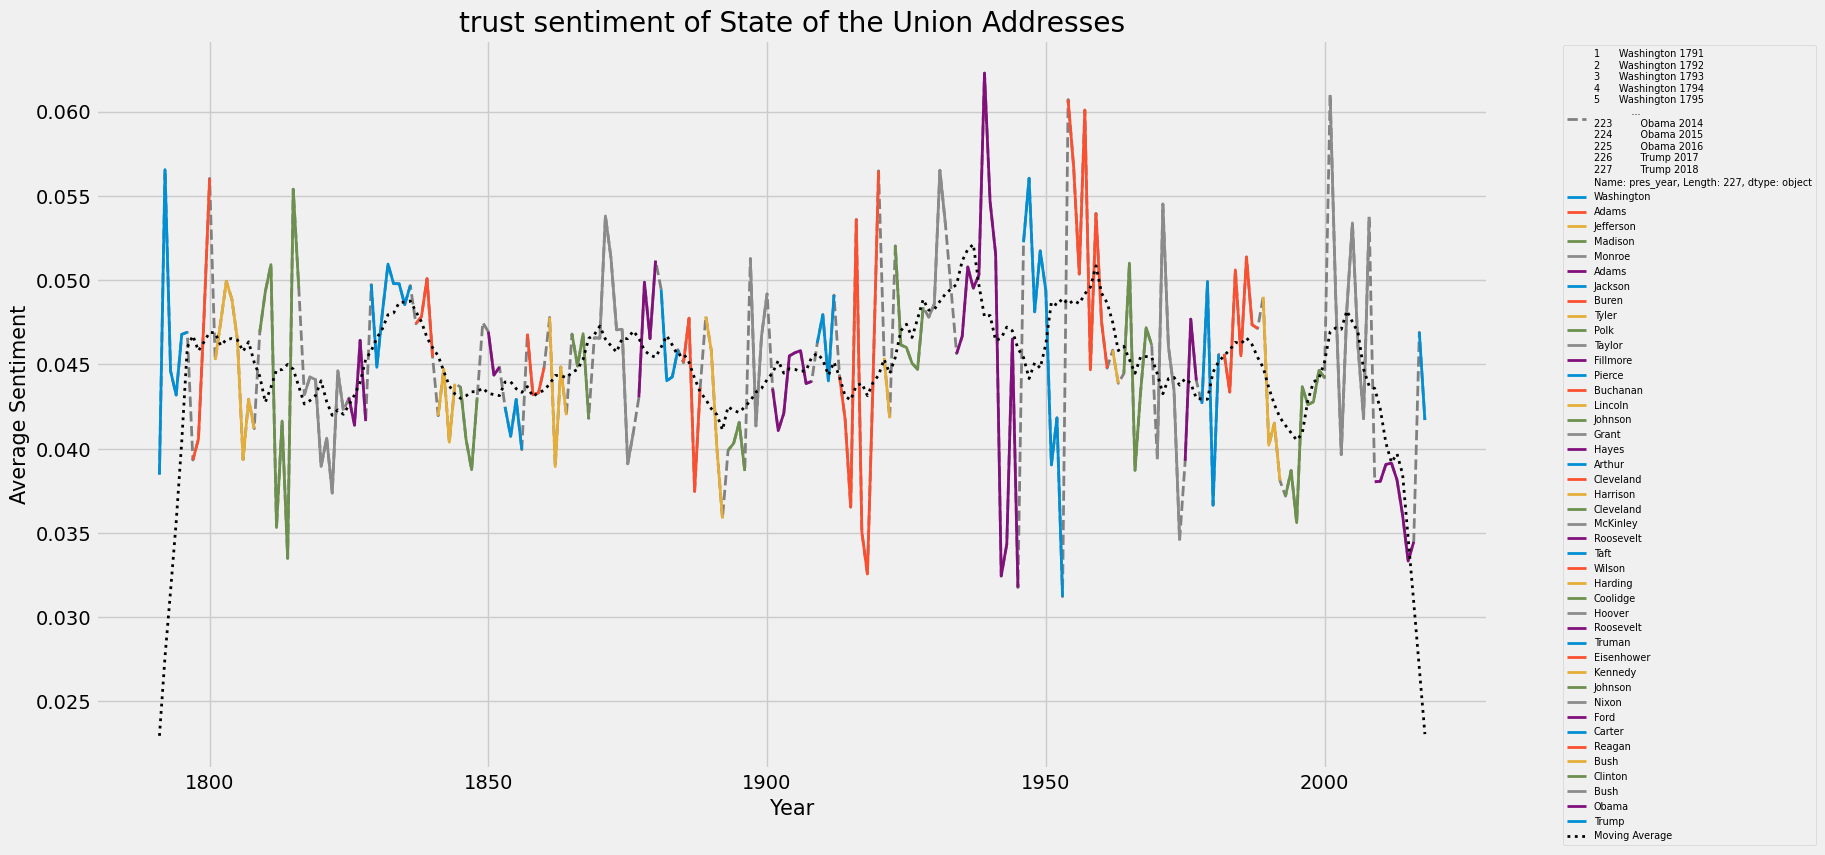

In [34]:
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

for emotion in emotions:
    fig,ax = plt.subplots()
    y = sotunrc2[emotion]
    ctr=0
    plt.plot(x,y,label = sotunrc2['pres_year'],linestyle = 'dashed',linewidth=2, color = 'gray')
    for presyrs in presyears:
        plt.plot(presyrs,y[ctr:ctr+len(presyrs)],label = sotunrc2.iloc[ctr]['pres'],linewidth=2)
        ctr+=len(presyrs)
    plt.plot(x,movingaverage(y, 10), color='k', linewidth=2, linestyle=':', label = 'Moving Average')
    plt.title('{} sentiment of State of the Union Addresses'.format(emotion, fontsize=24))
    plt.xlabel('Year', fontsize=15)
    plt.ylabel('Average Sentiment', fontsize=15)
    plt.legend(loc='best', fontsize=7, bbox_to_anchor=(1.05, 1))
    image_format = "png"
    image_name = "sotu_%s_sentiment.%s"%(emotion,image_format)
    fig.savefig(image_name, format=image_format, dpi = 300)
    plt.show()

C:\Users\F0040RP\AppData\Local\Temp\ipykernel_28056\244775042.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\F0040RP\AppData\Local\Temp\ipykernel_28056\244775042.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\F0040RP\AppData\Local\Temp\ipykernel_28056\244775042.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\F0040RP\AppData\Local\Temp\ipykernel_28056\244775042.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\F0040RP\AppData\Local\Temp\ipykernel_28056\244775042.py:27: UserWarning: Matplotlib is currently us

NameError: name 'hp' is not defined

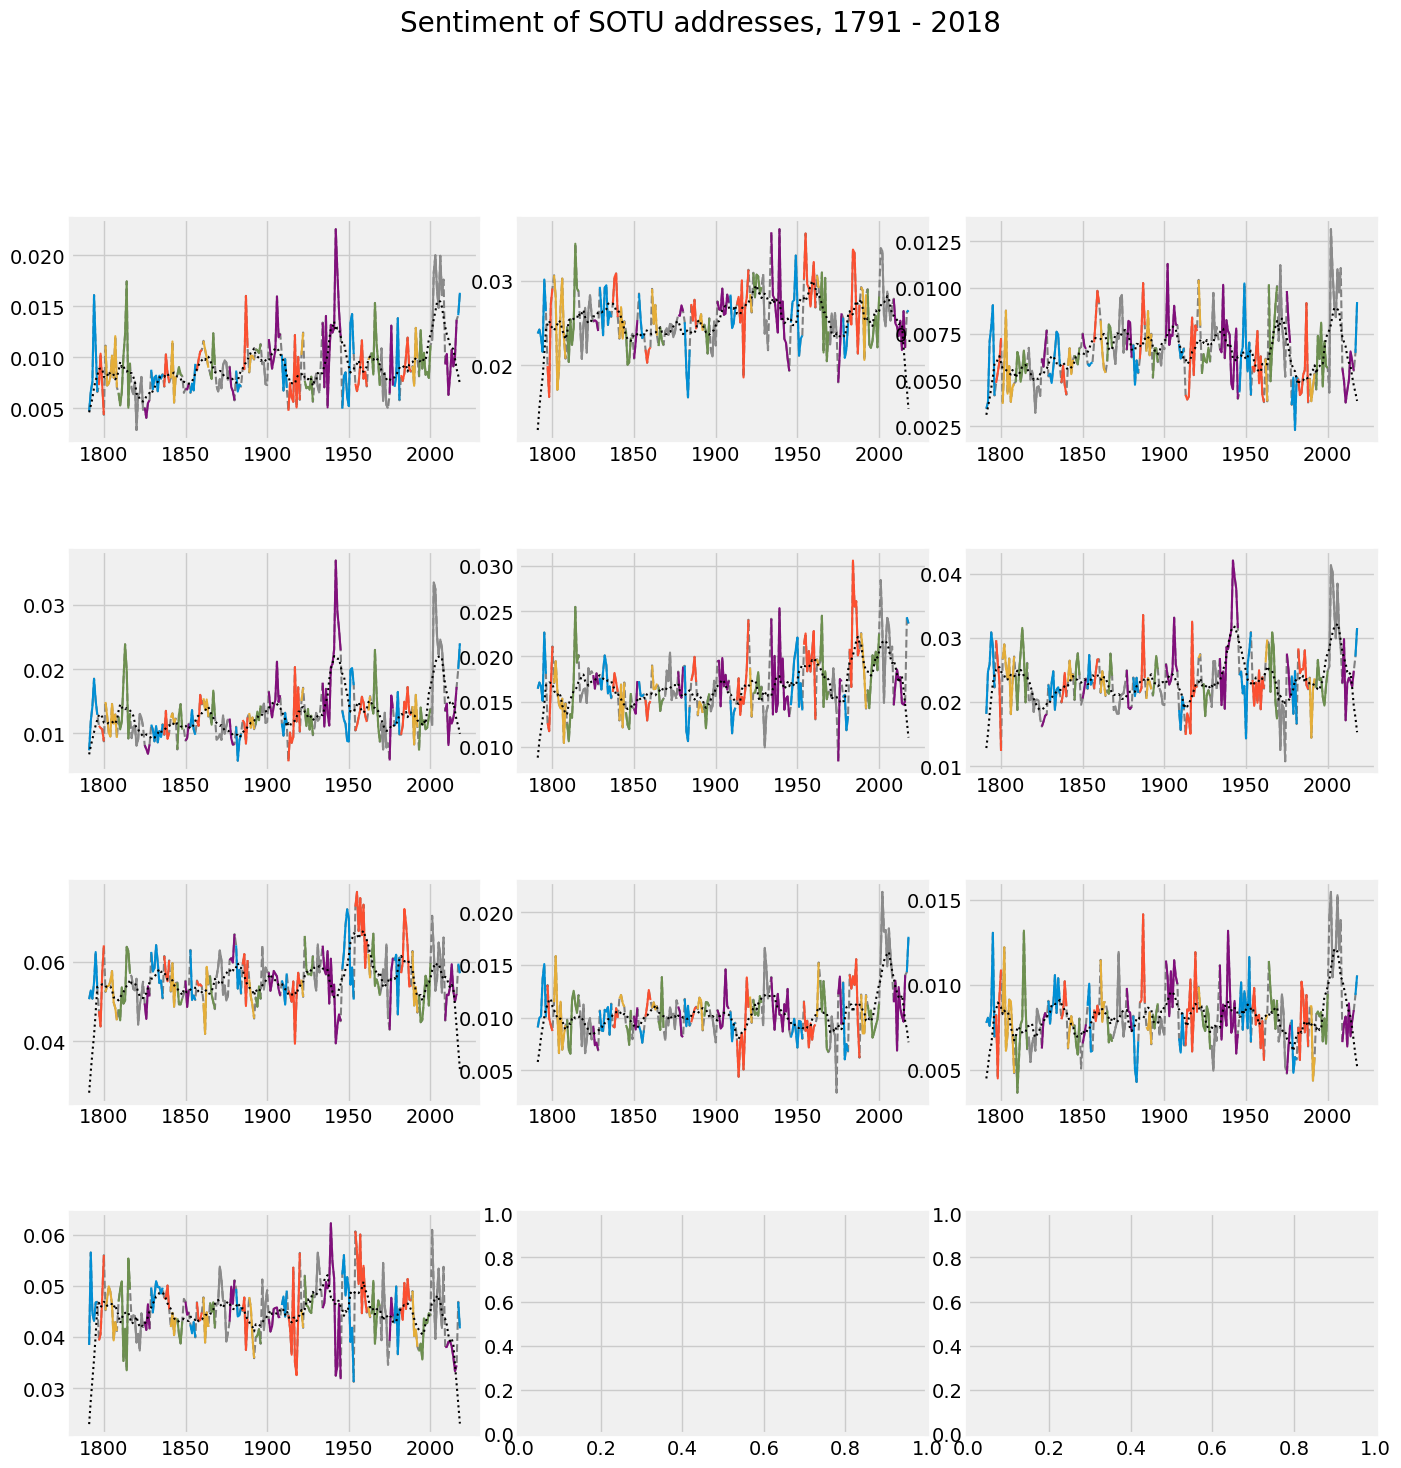

In [44]:
#length = sum([len(hp[book]) for book in hp])
#x = np.linspace(0, length - 1, num=length)

fig, ax = plt.subplots(4, 3, figsize=(15, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.1)
fig.suptitle('Sentiment of SOTU addresses, 1791 - 2018', fontsize=20, y=1.02)
fig.subplots_adjust(top=0.88)

ax = ax.ravel()

for i, emotion in enumerate(emotions):
    #fig,ax = plt.subplots()
    y = sotunrc2[emotion]
    ctr=0
    ax[i].plot(x,y,label = sotunrc2['pres_year'],linestyle = 'dashed',linewidth=1.5, color = 'gray')
    for presyrs in presyears:
        ax[i].plot(presyrs,y[ctr:ctr+len(presyrs)],label = sotunrc2.iloc[ctr]['pres'],linewidth=1.5)
        ctr+=len(presyrs)
    ax[i].plot(x,movingaverage(y, 10), color='k', linewidth=1.5, linestyle=':', label = 'Moving Average')
    #ax[i].title('{} sentiment of State of the Union Addresses'.format(emotion, fontsize=24))
    #ax[i].xlabel('Year', fontsize=15)
    #ax[i].ylabel('Average Sentiment', fontsize=15)
    #ax[i].legend(loc='best', fontsize=7, bbox_to_anchor=(1.05, 1))
    image_format = "png"
    image_name = "sotu_%s_sentiment.%s"%(emotion,image_format)
    fig.savefig(image_name, format=image_format, dpi = 300)
    fig.show()

#for i, emotion in enumerate(emotions):
#    y = [hp_df.loc[book].loc[hp[book][chapter][0]][emotion] for book in hp for chapter in hp[book]]
#    for book in book_indices:
#        ax[i].plot(x[book_indices[book][0]: book_indices[book][1]],
#                 y[book_indices[book][0]: book_indices[book][1]],
#                 label=book, linewidth=2)
#
#    ax[i].set_title('{} Sentiment'.format(emotion.title()))
#    ax[i].set_xticks([])

fig.legend(list(hp), loc='upper right', fontsize=15, bbox_to_anchor=(.85, .2))
fig.tight_layout()
fig.delaxes(ax[-1])
fig.delaxes(ax[-2])
plt.show()

In [41]:
ax[i]

<AxesSubplot:>

## Topic Modeling: A Brief Introduction

1. XX

In [5]:
sotudir = Path(Path.cwd().parent,"state-of-the-union-dataset","txt")
pathlist = sotudir.glob("*.txt")
for path in pathlist:
    print(path)

C:\Users\F0040RP\Documents\DartLib_RDS\textAnalysis\topics-and-emotions
C:\Users\F0040RP\Documents\DartLib_RDS\textAnalysis\state-of-the-union-dataset\txt
C:\Users\F0040RP\Documents\DartLib_RDS\textAnalysis\state-of-the-union-dataset\txt\1790_Washington.txt
C:\Users\F0040RP\Documents\DartLib_RDS\textAnalysis\state-of-the-union-dataset\txt\1791_Washington.txt
C:\Users\F0040RP\Documents\DartLib_RDS\textAnalysis\state-of-the-union-dataset\txt\1792_Washington.txt
C:\Users\F0040RP\Documents\DartLib_RDS\textAnalysis\state-of-the-union-dataset\txt\1793_Washington.txt
C:\Users\F0040RP\Documents\DartLib_RDS\textAnalysis\state-of-the-union-dataset\txt\1794_Washington.txt
C:\Users\F0040RP\Documents\DartLib_RDS\textAnalysis\state-of-the-union-dataset\txt\1795_Washington.txt
C:\Users\F0040RP\Documents\DartLib_RDS\textAnalysis\state-of-the-union-dataset\txt\1796_Washington.txt
C:\Users\F0040RP\Documents\DartLib_RDS\textAnalysis\state-of-the-union-dataset\txt\1797_Adams.txt
C:\Users\F0040RP\Documents

For this topic modeling activity, I am following code published in Shashank Kapadia's article: [End to End Topic Modeling in Python](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0) (*Towards Data Science*, 2019). This code uses the gensim package.


Check coherence scores: https://medium.com/analytics-vidhya/topic-modeling-using-gensim-lda-in-python-48eaa2344920